https://github.com/martinarjovsky/WassersteinGAN

https://vincentherrmann.github.io/blog/wasserstein/

https://github.com/martinarjovsky/WassersteinGAN/issues/2

https://github.com/caogang/wgan-gp/blob/master/gan_cifar10.py

# To do:

* Clip and then intorudce logs (should go to -17,9)
* Add confidence intervals to (mean and std)
* Upload redshift 5
* Fix sns denisty plots
* Check for overfitting
* Play around with optimizers
* Clean code
* Revise and change architecture (less convs, polling, FC)
* Bigger cubes with no padding
* Use other standarizations of data
* Gradient penalty instead of weight clamping
* Locally connected layers
* Weight initialization
* Mini batch discrimination

In [1]:
from __future__ import print_function
#import argparse
import os
import random
import numpy as np

#import torch

import torch.multiprocessing as mp
mp.set_start_method('spawn')

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable, grad

import matplotlib.pyplot as plt
%matplotlib inline

import h5py

import itertools
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import matplotlib as mpl
import timeit

import seaborn as sns

ngpu = 1   

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#get_ipython().run_line_magic('run', '../mmd_gan/utils/power_spectrum_utils.py')
#get_ipython().run_line_magic('run', '../mmd_gan/utils/plot_utils.py')

def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')


def power_spectrum_np(cube, mean_raw_cube):
    """
    taken from: https://astronomy.stackexchange.com/questions/26431/tests-for-code-that-computes-two-point-correlation-function-of-galaxies
    
    cube = should be in shape [. x . x. x . x . ]
    mean_raw_cube = is the mean of the whole cube of that redshift
    """
    #print(cube.shape)
    nc = cube.shape[2]                # define how many cells your box has
    boxlen = 50.0           # define length of box
    Lambda = boxlen/4.0     # define an arbitrary wave length of a plane wave
    dx = boxlen/nc          # get size of a cell

    # create plane wave density field
#     density_field = np.zeros((nc, nc, nc), dtype='float')
#     for x in range(density_field.shape[0]):
#         density_field[x,:,:] = np.cos(2*np.pi*x*dx/Lambda)
    density_field = cube

#    # get overdensity field
#     delta = density_field/np.mean(density_field) - 1
    delta = density_field / mean_raw_cube - 1

    # get P(k) field: explot fft of data that is only real, not complex
    delta_k = np.abs(np.fft.rfftn(delta).round())
    Pk_field =  delta_k**2

    # get 3d array of index integer distances to k = (0, 0, 0)
    dist = np.minimum(np.arange(nc), np.arange(nc,0,-1))
    dist_z = np.arange(nc//2+1)
    dist *= dist
    dist_z *= dist_z
    dist_3d = np.sqrt(dist[:, None, None] + dist[:, None] + dist_z)

    # get unique distances and index which any distance stored in dist_3d 
    # will have in "distances" array
    distances, _ = np.unique(dist_3d, return_inverse=True)

    # average P(kx, ky, kz) to P(|k|)
    Pk = np.bincount(_, weights=Pk_field.ravel())/np.bincount(_)

    # compute "phyical" values of k
    dk = 2*np.pi/boxlen
    k = distances*dk
    
    # moving averages
    Pk = moving_average(np.asarray(Pk), 5)
    k = moving_average(np.asarray(k), 5)

    # plot results
#     fig = plt.figure(figsize=(9,6))
#     ax1 = fig.add_subplot(111)
# #     ax1.plot(k, Pk, label=r'$P(\mathbf{k})$')
#     ax1.plot(k, np.log10(Pk), 
#              alpha = 0.2,
#              label=r'$log(P(\mathbf{k}))$')
#     ax1.legend()
#     plt.show()

    return Pk, dk, k
    


def plot_power_spec(real_cube,        # should be inverse_transformed
                    generated_cube,   # should be inverse_transformed
                    raw_cube_mean,    # mean of the whole raw data cube (fields=z0.0)
                    save_plot,
                     show_plot,
                     redshift_fig_folder,
                    threads=1, 
                    MAS="CIC", 
                    axis=0, 
                    BoxSize=75.0/2048*128):
    """Takes as input;
    - Real cube: (batch_size x 1 x n x n x n) torch cuda FloatTensor,
    - Generated copy: (batch_size x 1 x n x n x n) torch cuda FloatTensor,
    - constant assignments: threads, MAS, axis, BoxSize.
    
    Returns;
    - Power spectrum plots of both cubes
    in the same figure.
    """
    real_cube = real_cube.reshape(-1,
                                  1,
                                  real_cube.shape[2],
                                  real_cube.shape[2],
                                  real_cube.shape[2])
    generated_cube = generated_cube.reshape(-1,
                                            1,
                                            generated_cube.shape[2],
                                            generated_cube.shape[2],
                                            generated_cube.shape[2])
    
    #print("number of samples of real and generated cubes = " + str(real_cube.shape[0]))

    plt.figure(figsize=(16,8))
    
    for cube_no in range(real_cube.shape[0]):
        
        delta_real_cube = real_cube[cube_no][0]
        delta_gen_cube = generated_cube[cube_no][0]
        
        Pk_real, dk_real, k_real = power_spectrum_np(cube = delta_real_cube, 
                                                     mean_raw_cube = raw_cube_mean)
        Pk_gen, dk_gen, k_gen = power_spectrum_np(cube = delta_gen_cube, 
                                                  mean_raw_cube = raw_cube_mean)
        
    
        plt.plot(np.log10(k_real), 
                 np.log10(Pk_real), 
                 color="b", 
                 alpha = 0.2,
                 label="Real Samples")
        plt.plot(np.log(k_gen), 
                 np.log10(Pk_gen), 
                 color="r",
                 alpha = 0.2,
                 label="Generated from Noise")
        plt.rcParams["font.size"] = 12
        plt.title("Power Spectrum Comparison - (Red: Real, Blue: Noise-Generated)")
        plt.xlabel('k')
        plt.ylabel('log10(Pk.k3D)')
        #plt.xlim(0, np.log10(3))
#         plt.legend()
    
    #if save_plot:
     #   plt.savefig(redshift_fig_folder + 'powerspectrum_' + str(t) + '.png', 
      #              bbox_inches='tight')
   
    plt.show()

In [3]:
def hist_plot(noise, real, log_plot, redshift_fig_folder) :
    """
    Args:
        real(): real data
        epoch(integer): epoch number
        file_name(string): name of the file
        hd (integer) : if 0 it's a histogram, if 1 it's a pdf
        
    """
    
    plt.figure(figsize = (20,10))
    plot_min = min(float(noise.min()), float(real.min()))
    plot_max = max(float(noise.max()), float(real.max()))
    plt.xlim(plot_min,plot_max)
    
    bins = np.linspace(plot_min,plot_max,400)
    
    real_label = "Real Subcube - Only Nonzero"
    noise_label = "Noise Subcube - Only Nonzero"
    
    for m in range(fake.size()[0]):
        plt.hist(real[m][0].flatten(), bins = bins, color = "b" , log = log_plot, alpha = 0.3, label = real_label, normed=True)
        plt.hist(noise[m][0].flatten(), bins = bins, color = "r" , log = log_plot, alpha= 0.3, label = noise_label, normed=True)

    #plt.legend()
    #plt.savefig(redshift_fig_folder + file_name, bbox_inches='tight')    
    plt.show()




def plot_loss(datalist, ylabel, log_):
    plt.figure(figsize=(20,10))
    
    if ylabel=='Wasserstein loss':
        plt.plot([-x for x in datalist], linewidth=2.5, color='b')
        
    else:
        plt.plot([x for x in datalist], linewidth=2.5, color='b')
        
    plt.ylabel(ylabel, fontsize=16)
    plt.yticks(fontsize=14)
    
    if ylabel=='Generator loss':
        plt.xlabel('Epoch', fontsize=16)
    else:
        plt.xlabel('Iterations', fontsize=16)
    plt.show()

def plot_means(real_list, fake_list):
    plt.figure(figsize=(20,10))
    plt.title('Histogram of means', fontsize=18)
    plt.xlim(0, max(max(real_list, fake_list)))
    
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.hist(fake_list, label='Generated', color='blue', normed=1);
    plt.hist(real_list, label='Real', color='green', normed=1);
    plt.legend(fontsize=16)
    plt.show() 

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """Function for dividing/truncating cmaps"""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap



#New
def visualize_cube(cube=None,      # array name
             edge_dim=None,        # edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=None,
#              stdev_to_white=-3,
             norm_multiply=1e2,
             size_magnitude = False,
             color_map="Blues",
             plot_show = False,
             plot_save = False,
             save_fig = False,
                  raw_cube_max = False):  

    """Takes as input;
    - cube: A 3d numpy array to visualize,
    - edge_dim: edge length,
    - fig_size: Figure size for the plot,
    - norm_multiply: Multiplication factor to enable matplotlib to 'see' the particles,
    - color_map: A maplotlib colormap of your choice,
    
    Returns: 
    - The cube visualization
    - Also saves PNG file
    
    TODO:
    - Plot only the values > some value
    - timing of each part
    
    PROBLEMS:
    - Plotting everypoint (not truncating) with colorscale from 0 to 1 takes a really long time
    - size = magnitude -> some dots get too big to obscure view
    
    
    """
    cube = cube/raw_cube_max
    
    time_start = timeit.default_timer()
        
    cube_size = edge_dim
    edge = np.array([*range(cube_size)])
    
    end_x = start_cube_index_x + cube_size
    end_y = start_cube_index_y + cube_size
    end_z = start_cube_index_z + cube_size
    
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection='3d')

    data_value = cube[start_cube_index_x:end_x,
                      start_cube_index_y:end_y,
                      start_cube_index_z:end_z]
    
    x,y,z = edge,edge,edge
    product = [*itertools.product(x,y,z)]
    
    X = np.array([product[k][0] for k in [*range(len(product))]])
    Y = np.array([product[k][1] for k in [*range(len(product))]])
    Z = np.array([product[k][2] for k in [*range(len(product))]])
    
    time_1 = timeit.default_timer()
#     print("Section 1 time = " + str((time_1 - time_start)/60))
    # avg: 0.02 sec
    
    ## map data to 1d array that corresponds to the axis values in the product array
    data_1dim = np.array([data_value[X[i]][Y[i]][Z[i]] for i in [*range(len(product))]])
#     print("data_1dim = " + str(data_1dim))
    
#     initial_mean = np.mean(data_1dim) - stdev_to_white*np.std(data_1dim)
#     mask = data_1dim / raw_cube_max > 0.
#     mask = mask.astype(np.int)
    """
    Only plot the highest 10K points
    """
    n = -250000
    sorted_data = np.sort(data_1dim)
    n_max = sorted_data[n]
    mask = data_1dim > n_max
    mask = mask.astype(np.int)    
    

    """
    Masking part of the data to speed up plotting time
    (may use just radius limiting below)
    """
    
    data_1dim = np.multiply(mask,data_1dim)
    ## mask X,Y,Z to match the dimensions of the data
    X, Y, Z, data_1dim = [axis[np.where(data_1dim>0)] for axis in [X,Y,Z,data_1dim]]
    
    print("data_1dim len = " + str(len(data_1dim)))
    """
    norm_multiply = function argument
    data_1dim = data in one dimension, flattened
    nn.linalg.norm = return one of eight different matrix norms
    The nn.linalg.norm should not be used due to the fact 
    that each subcube has different norms. Use the maximum of
    the whole cube and mitigate with norm_multiply if 
    no points are seen in the 3D plot.
    """

    if size_magnitude == True:
        s = norm_multiply * data_1dim
    else:
        s = norm_multiply * np.ones_like(a = data_1dim)
    
    """
    s radius limit
    """
#     print("s = " + str(s))

    time_2 = timeit.default_timer()
#     print("Section 2 time = " + str((time_2 - time_1)/60))
    # avg: 0.03 sec

#     try:
    if True:
        # checking min, max , mean of s
        print("scatter size mean = " + str(s.mean()))
        print("scatter size max = " + str(s.max()))
        print("scatter size min = " + str(s.min()))


        """
        Truncating the colormap has the effect of showing even really small
        densities. 
        0 = white
        1 = full color
        minval = 0.99 -> even 0 densities are shown with 0.99 color
        n = number of division between minval and maxval of color
        https://matplotlib.org/tutorials/colors/colormaps.html
        """
#         cmap = plt.get_cmap(color_map)
#         new_cmap = truncate_colormap(cmap, 
#                                      minval = 0, 
#                                      maxval = 1,
#                                      n=100)

        cmap = colors.LinearSegmentedColormap.from_list("", ["white","blue"])
        new_cmap = truncate_colormap(cmap, 
                                     minval = 0.5, 
                                     maxval = 1,
                                     n=100)

        ## IGNORE BELOW 3D PLOT FORMATTING 

        ## plot cube

        cube_definition = [(start_cube_index_x, start_cube_index_x, start_cube_index_x),
                          (start_cube_index_x, start_cube_index_x+edge_dim, start_cube_index_x),
                          (start_cube_index_x + edge_dim, start_cube_index_x, start_cube_index_x),
                          (start_cube_index_x, start_cube_index_x, start_cube_index_x+edge_dim)]

        cube_definition_array = [
            np.array(list(item))
            for item in cube_definition
        ]

        points = []
        points += cube_definition_array
        vectors = [
            cube_definition_array[1] - cube_definition_array[0],
            cube_definition_array[2] - cube_definition_array[0],
            cube_definition_array[3] - cube_definition_array[0]
        ]


        points += [cube_definition_array[0] + vectors[0] + vectors[1]]
        points += [cube_definition_array[0] + vectors[0] + vectors[2]]
        points += [cube_definition_array[0] + vectors[1] + vectors[2]]
        points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

        points = np.array(points)

        edges = [
            [points[0], points[3], points[5], points[1]],
            [points[1], points[5], points[7], points[4]],
            [points[4], points[2], points[6], points[7]],
            [points[2], points[6], points[3], points[0]],
            [points[0], points[2], points[4], points[1]],
            [points[3], points[6], points[7], points[5]]
        ]

    #     ax.fig.add_subplot(111, projection='3d')

        faces = Poly3DCollection(edges, linewidths=1, edgecolors='k',)
        faces.set_facecolor((0,0,1,0)) ## set transparent facecolor to the cube

        ax.add_collection3d(faces)

        ax.scatter(points[:,0], points[:,1], points[:,2], s=0)

        ax.set_aspect('equal')

        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')

        ax.xaxis.set_major_locator(MultipleLocator(edge_dim))
        ax.yaxis.set_major_locator(MultipleLocator(edge_dim))
        ax.zaxis.set_major_locator(MultipleLocator(edge_dim))

        ax.grid(False)

        ax.set_xlim3d(0,edge_dim)
        ax.set_ylim3d(0,edge_dim)
        ax.set_zlim3d(0,edge_dim)
    #     ax.get_frame_on()

        ax.xaxis._axinfo['tick']['inward_factor'] = 0
        ax.xaxis._axinfo['tick']['outward_factor'] = 0
        ax.yaxis._axinfo['tick']['inward_factor'] = 0
        ax.yaxis._axinfo['tick']['outward_factor'] = 0
        ax.zaxis._axinfo['tick']['inward_factor'] = 0
        ax.zaxis._axinfo['tick']['outward_factor'] = 0
        
        time_3 = timeit.default_timer()
#         print("Section 3 time = " + str((time_3 - time_2)/60))
        # avg: 0.0005 sec

        ax.scatter(X, Y, Z,       ## axis vals
                   c=data_1dim,   ## data, mapped to 1-dim
                   cmap=new_cmap,
                   s=s,           ## sizes - dims multiplied by each data point's magnitude
#                    alpha=data_1dim,
                   alpha = 0.25,
                   vmin=0,
                   vmax=1,
                   edgecolors="face")
        
        time_4 = timeit.default_timer()
#         print("Section 4 time = " + str((time_4 - time_3)/60))
        # avg: 0.11 sec
    
        if plot_show:
            plt.show()
        
        time_5 = timeit.default_timer()
#         print("Section 5 time = " + str((time_5 - time_4)/60))
        # avg:  sec

        if plot_save:
            if save_fig:
                fig.savefig(save_fig,bbox_inches='tight')

        plt.close(fig)
    
#     except:
#         pass

viz_multiplier = 1e0           # the norm multiplier in the 3D visualization
plot_show_3d = True            # shows the 3d scatter plot
plot_save_3d = False           # whether to save or not as png
scatter_size_magnitude = False 

In [17]:
def define_test(s_test, s_train):
    #2048/16=128
    m=8
    x=random.randint(0,m)*s_train
    y=random.randint(0,m)*s_train
    z=random.randint(0,m)*s_train
    #print(x,y,z)
    return {'x':[x,x+s_test], 'y':[y,y+s_test], 'z':[z,z+s_test]}

def check_coords(test_coords, train_coords):
    valid=True
    for i in ['x','y','z']:
        r=(max(test_coords[i][0], 
               train_coords[i][0]), 
           min(test_coords[i][1],
               train_coords[i][1]))
        if r[0]<=r[1]:
            valid=False
    return valid

def get_samples(s_sample, nsamples, test_coords):
    #n is size of minibatch, get valid samples (not intersecting with test_coords)
    sample_list=[]
    m=2048-s_sample
    for n in range(nsamples):
        #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
        sample_valid=False
        while sample_valid==False:
            x = random.randint(0,m)
            y = random.randint(0,m)
            z = random.randint(0,m)
            sample_coords = {'x':[x,x+s_sample], 
                             'y':[y,y+s_sample], 
                             'z':[z,z+s_sample]}
            
            sample_valid = check_coords(test_coords, sample_coords)
        
        sample_list.append(sample_coords)
    
    #print("Sampling finished.")    
    #Load cube and get samples and convert them to np.arrays
    sample_array=[]
    #datapath='../../../../../'
    #f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    #f=f['delta_HI']
    
    counter = 0
    for c in sample_list:
        a = f[c['x'][0]:c['x'][1],
              c['y'][0]:c['y'][1],
              c['z'][0]:c['z'][1]]
        
        sample_array.append( np.array(a))
    
    return np.array(sample_array)

In [18]:
class HydrogenDataset(Dataset):
    """Hydrogen Dataset"""

    def __init__(self, s_test, s_sample, nsamples,transform, rotate):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        #file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        #print("The whole file size is " + str(int(file_size)) + " MBs")
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        self.s_test = s_test
        self.s_sample = s_sample
        self.t_coords = define_test(self.s_test,self.s_sample)
        self.nsamples = nsamples
        self.redshift = redshift
        self.transform=transform
        self.rotate=rotate

    def __len__(self):
        # Function called when len(self) is executed
        return self.nsamples

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        sample = get_samples(s_sample = self.s_sample,
                             nsamples = 1,
                             test_coords = self.t_coords)
        
        if self.rotate==True:
            t=random.randint(1,4)
            if t==4:
                sample=sample
            else:
                axis=random.choice([(0,1), (0,2), (1,0), (1,2), (2,0), (2,1) ])
                sample=np.rot90(sample, t, axis)
        
        #sample=np.array(sample)
        if self.transform=='max':
            #print(sample.shape)
            sample = sample / self.max_cube
        if self.transform=='normalize':
            #sample = (sample-mean_5)/std_5
            sample = (sample-mean_5)/std_5
            #sample[sample <10**2]==0
            #sample[sample > 3*std_5]==3*std_5
            #sample=np.log(sample+1)
        if self.transform=='clip_log':
            sample[sample <10**2]==0
            sample[sample > 3*std_5]==3*std_5
            sample=np.log(sample+1)
            
            
        if self.transform=='log':
            sample= np.log(sample+1)
        #print(np.array(sample).shape)
    
        sample=sample.reshape((1, self.s_sample, self.s_sample, self.s_sample))

        return torch.tensor(sample)

# Helper functions

In [7]:
#f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
#f=f['delta_HI']

def get_statistics(datapath, redshift):
    f_ = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f_['delta_HI']
    
    max_list, min_list, mean_list, variance_list= [], [], [], []
   
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
        min_list.append(np.min(f[i:i+1,:,:]))
        mean_list.append(np.mean(f[i:i+1,:,:]))
        #variance_list.append(np.mean(np.square(f[i:i+1,:,:] - mean_cube)))
    #mean_cube = np.mean(mean_list)
    #for i in range(f.shape[0]):
    
    f.close()
    
    max_cube = max(max_list)
    min_cube = min(min_list)
    mean_cube = np.mean(mean_list)
    #stddev_cube = np.sqrt(np.mean(variance_list))
    return max_cube, min_cube, mean_cube   

def get_max_cube(datapath, redshift):
    f= h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f['delta_HI']
    max_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
    max_cube = max(max_list)
   
    return max_cube

def get_min_cube(datapath, redshift):
    min_list = [] 
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        min_list.append(np.min(f[i:i+1,:,:]))
    min_cube = min(min_list)
    return min_cube

def get_mean_cube(datapath, redshift):
    mean_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        mean_list.append(np.mean(f[i:i+1,:,:]))
    mean_cube = np.mean(mean_list)
    return mean_cube

def get_stddev_cube(datapath, redshift, mean_cube):
    variance_list = []
    for i in range(f.shape[0]):
        variance_list.append(np.mean(np.square(f[i:i+1,:,:] - mean_cube)))
    stddev_cube = np.sqrt(np.mean(variance_list))
    return stddev_cube

In [8]:
#mean_5=get_mean_cube('../../../../../','5.0')
#std_5=get_stddev_cube('../../../../../','5.0',mean_5)
mean_5=14592.24
std_5=922711.56
max_5=4376932000
mask_value=10**2

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

#https://github.com/caogang/wgan-gp/blob/master/gan_cifar10.py
def calc_gradient_penalty(netD, real_data, fake_data):
    # print "real_data: ", real_data.size(), fake_data.size()
    BATCH_SIZE=batchSize
    LAMBDA=10
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(BATCH_SIZE, real_data.nelement()//BATCH_SIZE).contiguous().view(BATCH_SIZE, 1, s_sample, s_sample,s_sample)
    alpha = alpha.cuda() if cuda else alpha

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    if cuda:
        interpolates = interpolates.cuda()
    interpolates = Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda() if cuda else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty


# New Architecture (Atakan)

In [10]:
#netD=N_Disc(s_sample,0,0,0,0.2, False)
#embedded_cube_dimension,fc1_hidden_dim, fc2_output_dim, 
#                embedding_dim, leakyrelu_const
#netG=N_Gen(1,0, 0, 0, 0.2)

# MLP

In [11]:
class MLP_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu):
        super(MLP_G, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ngf
            nn.Linear(nz, ngf),
            nn.SELU(True),
            nn.Linear(ngf, ngf),
            nn.SELU(True),
            nn.Linear(ngf, ngf),
            nn.SELU(True),
            nn.Linear(ngf,  nc * isize * isize *isize),
            nn.SELU(True),
            #nn.Linear(ngf*8, nc * isize * isize *isize),
            #nn.ReLU(True)
            #nn.Tanh()
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0), input.size(1))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(output.size(0), self.nc, self.isize, self.isize, self.isize)

In [12]:
class MLP_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu):
        super(MLP_D, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ndf
            nn.Linear(nc * isize * isize *isize, ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(ndf, ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(ndf, ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(ndf, ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(ndf, 1),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Linear(ndf, 1)
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0),
                           input.size(1) * input.size(2) * input.size(3) *input.size(4))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        output = output.mean(0)
        return output.view(1)

In [13]:
def plot_densities(fake, real, log_):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(xlabel='big', ylabel='big', title='Density')
    sns.set(rc={'figure.figsize':(20,10),"lines.linewidth": 3})
    #plt.subplots(figsize=(20,10))
    #ax.set_ylim(0,0.6)
    #ax.set_xlim(0, )
    bw=1
    eps=0.00000000001
    eps=0
    grid=200
    n=0
    if log_==True:
        fake=np.log(fake+eps)
        real=np.log(real+eps)
    for m in range(fake.shape[0]):
        n+=1
        if n==1:
            sns.kdeplot(fake[m][0].flatten(), ax=ax, bw=bw, cut=0, label='Generated', color='blue', gridsize=grid);
            sns.kdeplot(real[m][0].flatten(), ax=ax, bw=bw, cut=0, label='Real' ,color='green',gridsize=grid);
        else:
            sns.kdeplot(fake[m][0].flatten(), ax=ax, bw=bw, cut=0, color='blue', gridsize=grid);
            sns.kdeplot(real[m][0].flatten(), ax=ax, bw=bw, cut=0,color='green', gridsize=grid);
        
        ax.set_title("Densities of log HI mass",fontsize=25)
        ax.tick_params(labelsize=20)
        plt.setp(ax.get_legend().get_texts(), fontsize='22')
    plt.show()

In [19]:
#Define nets

redshift='5.0'
n_samples =9600
s_sample =64

s=64
ngf = 390      
ndf = ngf      
batchSize = 16
k=4

cuda=True
workers = 0

# imageSize = 128
nz = 100       # 'size of the latent z vector'

niter = 100      # 'number of epochs to train for'
cuda = True
#"first_iteration/saved/netG_epoch_22.pth" 
netG_arg = ""        # "path to netG (to continue training) "
netD_arg =  ""      # "path to netD (to continue training)"
outf = "."       # 'folder to output images and model checkpoints'
manualSeed = 1   # 'manual seed'

#.0002
#Default: 0.00005
lrD = 0.005
lrG = 0.005
Diters=300
#Default .01
clamp_lower=-.001
clamp_upper=.001

#n_samples = 100 # number of subcubes to sample
experiment='first_iteration/'

real_label = 1
fake_label = -1

ngpu=1
device = torch.device("cuda:0" if cuda else "cpu")

# number of channels
nc = 1

datapath='../../../../../'
f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
f=f['delta_HI']
    
dataset = HydrogenDataset( s_test = 1024, 
                            s_sample = s_sample, 
                            nsamples = n_samples, 
                            transform='normalize',
                            rotate=True)

#dataset = sampled_subcubes
#sampled_subcubes=0
workers=0
dataloader = torch.utils.data.DataLoader(dataset, 
                                         #batch_size=opt.batchSize,
                                         batch_size = batchSize,
                                         shuffle=True, 
                                         #num_workers=int(opt.workers)
                                         num_workers=int(workers) )


#self, isize, nz, nc, ndf, ngpu
#netG = DCGAN_G(ngpu, kernel=k, bias=True, dilation=1).to(device)
netG = MLP_G(s_sample, nz, 1, ngf, ngpu).to(device)

netG.apply(weights_init)
# if opt.netG != '':
#     netG.load_state_dict(torch.load(opt.netG))
if netG_arg != '':
    netG.load_state_dict(torch.load(netG_arg))
print(netG)

#netD = DCGAN_D(ngpu, kernel=k, bias=True, dilation=1).to(device)
netD = MLP_D(s_sample, nz, 1, ndf, ngpu).to(device)
netD.apply(weights_init)
if netD_arg != '':
    netD.load_state_dict(torch.load(netD_arg))
print(netD)
''''''

MLP_G(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=390, bias=True)
    (1): SELU(inplace)
    (2): Linear(in_features=390, out_features=390, bias=True)
    (3): SELU(inplace)
    (4): Linear(in_features=390, out_features=390, bias=True)
    (5): SELU(inplace)
    (6): Linear(in_features=390, out_features=262144, bias=True)
    (7): SELU(inplace)
  )
)
MLP_D(
  (main): Sequential(
    (0): Linear(in_features=262144, out_features=390, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=390, out_features=390, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=390, out_features=390, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=390, out_features=390, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Linear(in_features=390, out_features=1, bias=True)
  )
)


''

[0/100][300/600][1] Loss_D: -0.020547 Loss_G: 133.215668 Loss_D_real: -0.000487 Loss_D_fake 0.020059
[0/100][600/600][2] Loss_D: -7.934754 Loss_G: 75963.414062 Loss_D_real: -0.001269 Loss_D_fake 7.933485
Fake:
data_1dim len = 249999
scatter size mean = 100.0
scatter size max = 100.0
scatter size min = 100.0


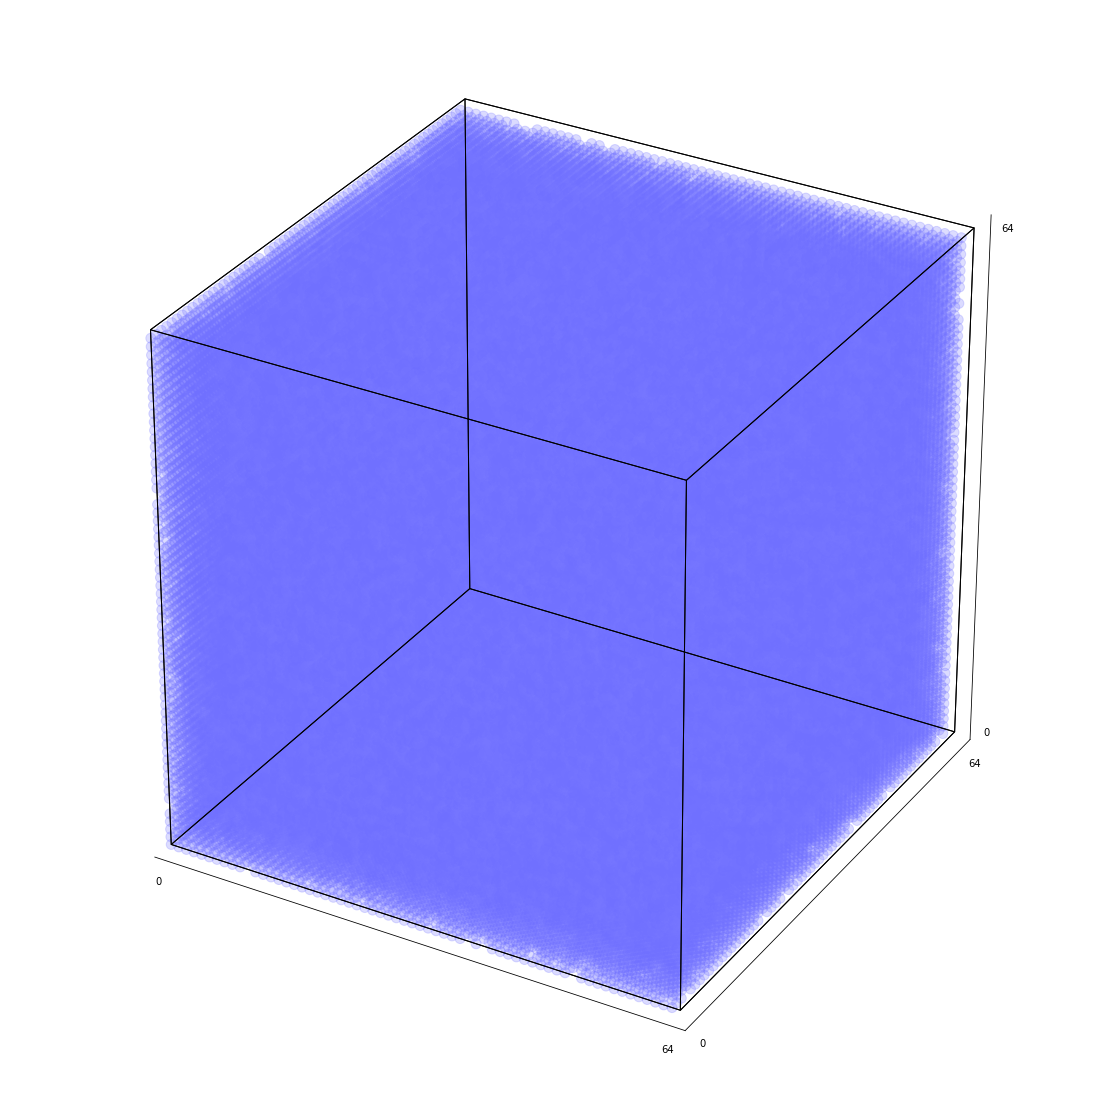

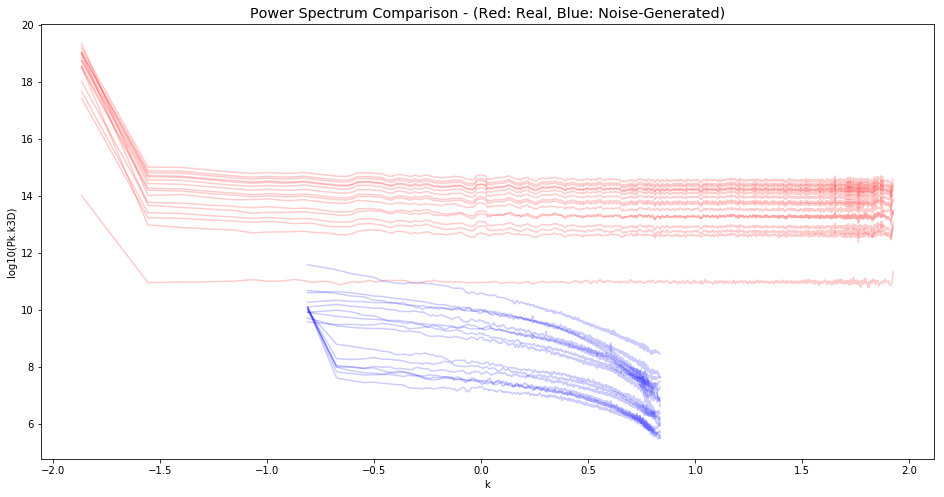

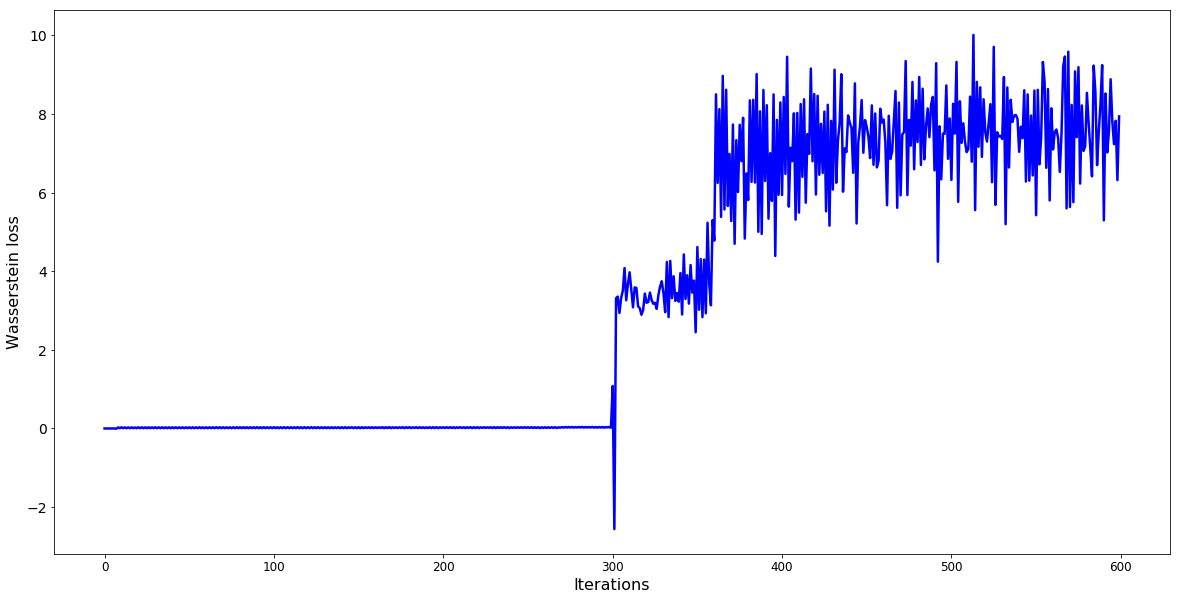

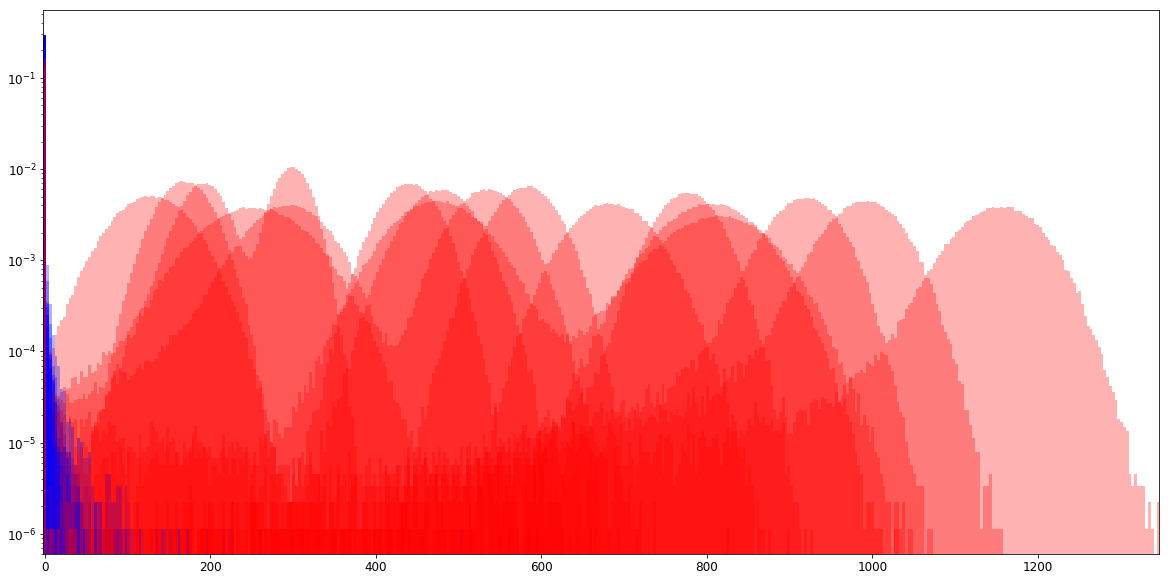

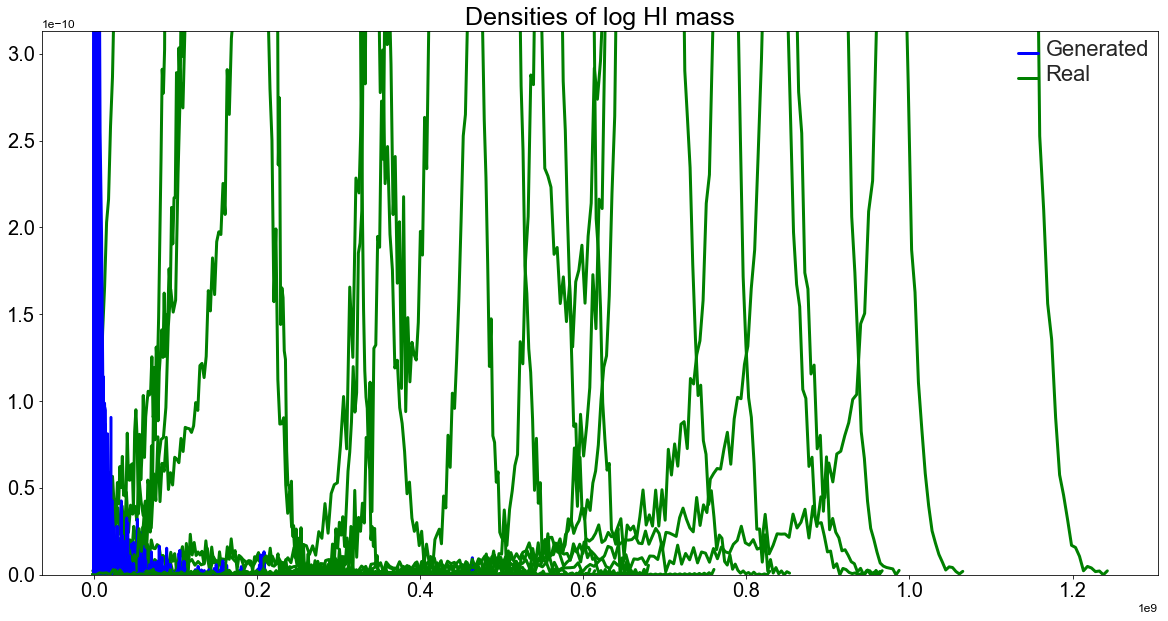

---------------------------------------------------------------------------------------
[1/100][300/600][3] Loss_D: -45.291313 Loss_G: 109242.117188 Loss_D_real: 0.001591 Loss_D_fake 45.292904
[1/100][600/600][4] Loss_D: -17.394438 Loss_G: 3502.174316 Loss_D_real: 0.002584 Loss_D_fake 17.397022
Fake:
data_1dim len = 8255
scatter size mean = 100.0
scatter size max = 100.0
scatter size min = 100.0


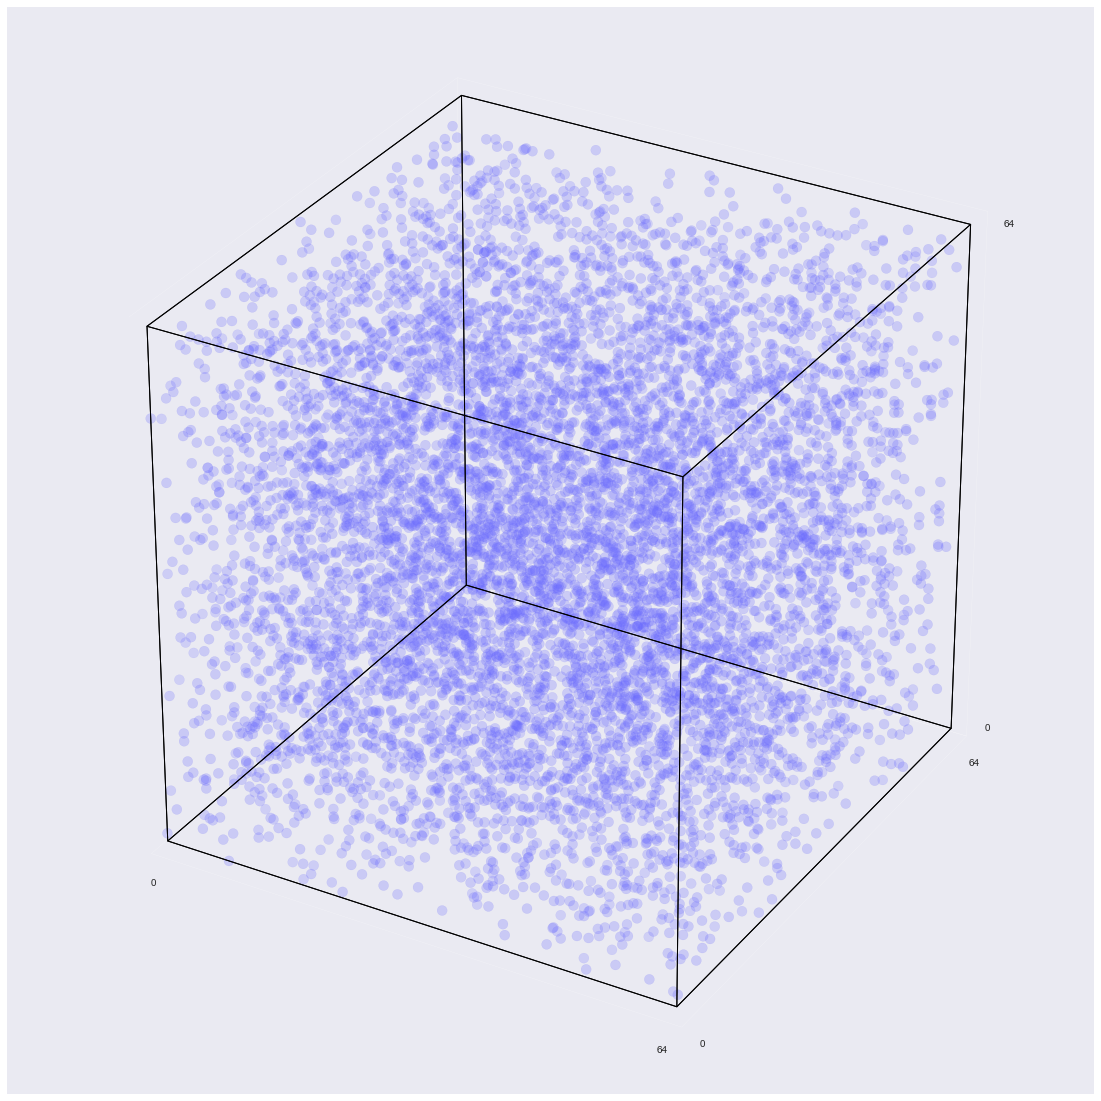

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log10


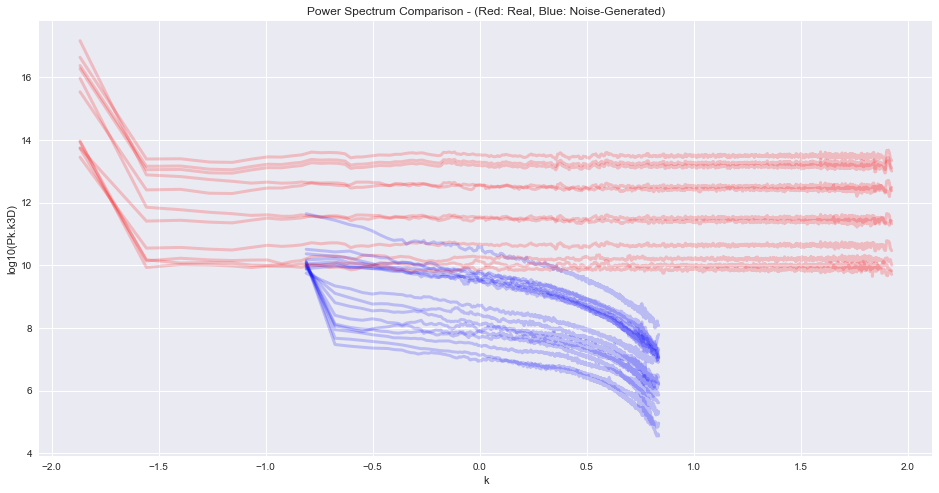

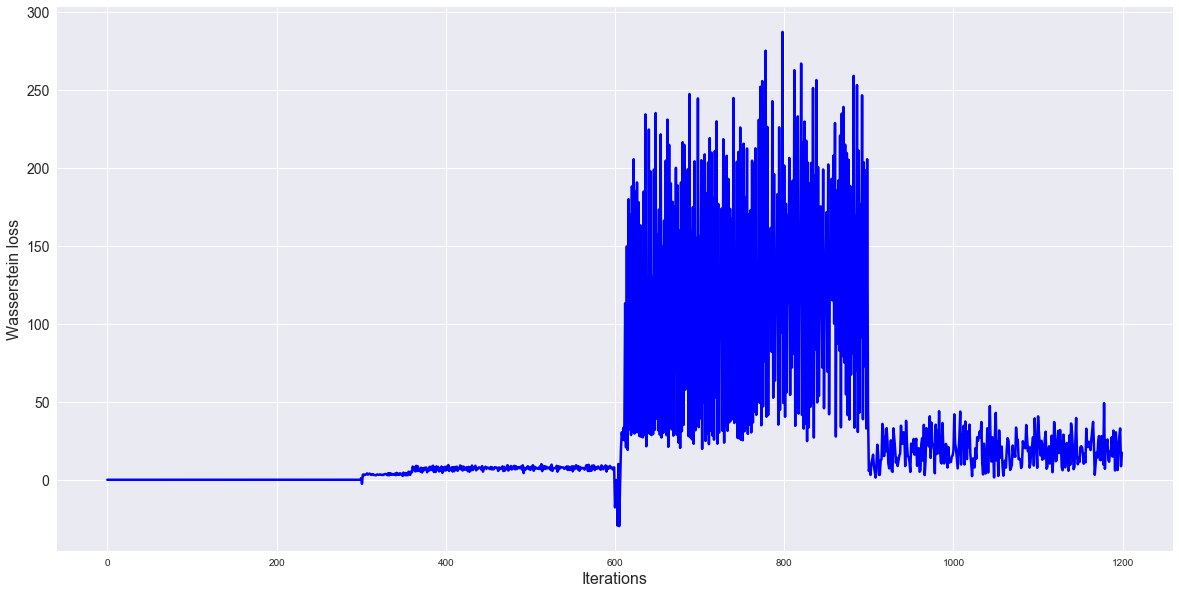

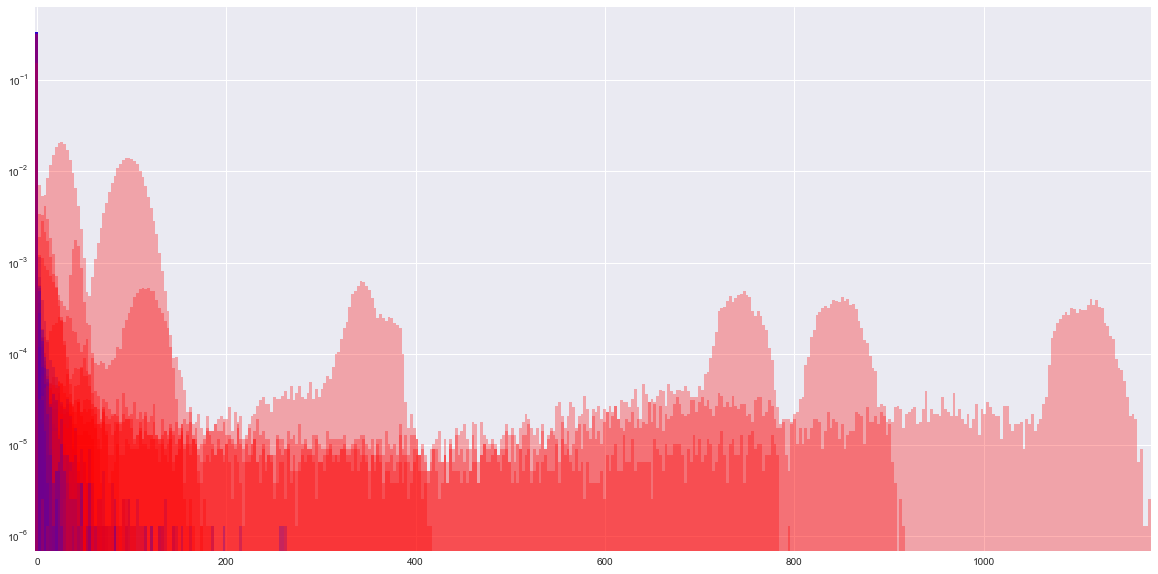

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:35: RuntimeWarning: invalid value encountered in multiply
  JFAC = J**2*FAC1
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


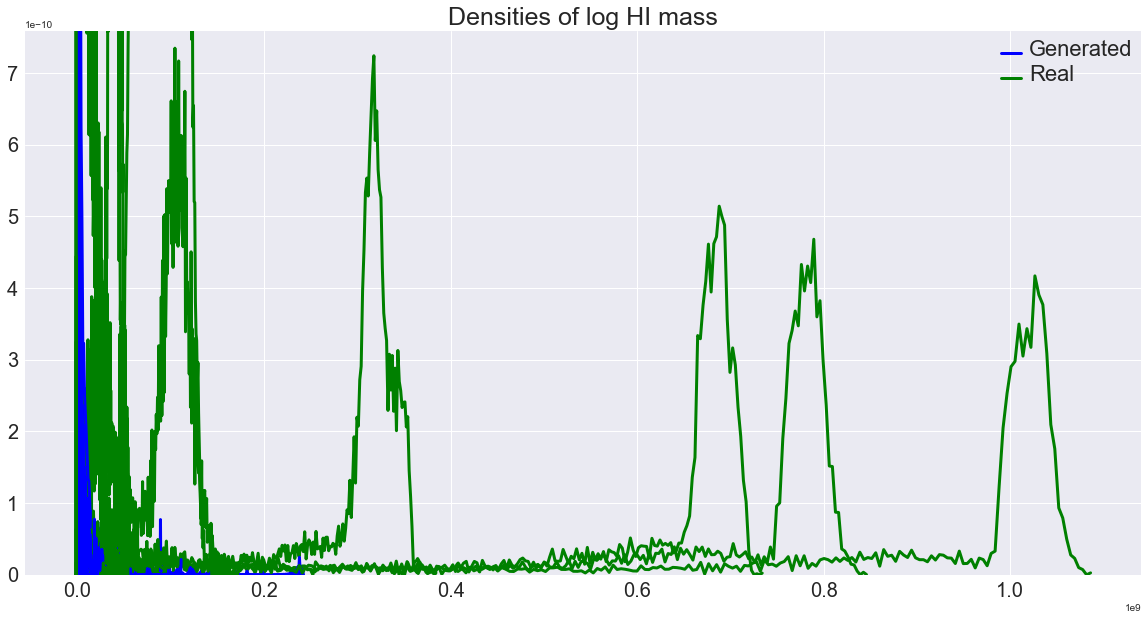

---------------------------------------------------------------------------------------
[2/100][300/600][5] Loss_D: -11.883787 Loss_G: 36542.117188 Loss_D_real: 0.020604 Loss_D_fake 11.904391


In [ ]:
# setup optimizer
optimizerD = optim.RMSprop(netD.parameters(), lr = lrD)
optimizerG = optim.RMSprop(netG.parameters(), lr = lrG)

'''
optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizerD  = optim.Adam(netD.parameters(), lr=1e-3, betas=(0.9, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=1e-3, betas=(0.9, 0.999))
'''
wass_loss=[]
errG_l=[]
errD_real_l=[]
errD_fake_l=[]

input = torch.FloatTensor(batchSize, 1, s_sample, s_sample, s_sample)
noise = torch.FloatTensor(batchSize, nz,1,1,1, device=device).normal_(0,1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1,1).normal_(0, 1)
#fixed_noise = torch.FloatTensor(1, nz, 1, 1,1).normal_(0, 1)

one = torch.FloatTensor([1])
#one = torch.tensor(1, dtype=torch.float)
mone = one * -1

#torch.cuda.empty_cache()
if cuda==True:
    netD.cuda()
    netG.cuda()
    input = input.cuda()
    one, mone = one.cuda(), mone.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()


gen_iterations = 0
for epoch in range(niter):
    
    data_iter = iter(dataloader)
    i = 0
    while i < len(dataloader):
        
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
            
        j=0
        while j < Diters and i < len(dataloader):
            j += 1
            
            # clamp parameters to a cube
            for p in netD.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
                
            data=data_iter.next()
            #print(data.shape)
            i+=1
            
            real_cpu= data
            netD.zero_grad()
          
            batch_size=real_cpu.size(0)
            if cuda==True:
                real_cpu=real_cpu.cuda()
        
            input.resize_as_(real_cpu).copy_(real_cpu)
            inputv = Variable(input)
            #print(inputv.size())   
            errD_real=netD(inputv)
            
            #label = torch.full(size = (batch_size,), fill_value = real_label, device = device)
            #ones=[torch.ones(1).cuda(gpu) for _ in range(len(errD_real))]
            #print('errD_real: ', errD_real)
            errD_real.backward(one)
                
            #Train with fake
            noise.resize_(batchSize, nz, 1, 1, 1).normal_(0, 0.33)
            #noisev = Variable(noise, volatile = True) # totally freeze netG
            with torch.no_grad():
                noisev = Variable(noise) # totally freeze netG
                
            fake = Variable(netG(noisev).data)
            #print(fake.shape)
            inputv=fake
               
            errD_fake = netD(inputv)
            #print(errD_fake.shape)
            #label.fill_(fake_label)
            #print('errD_fake: ' ,errD_fake)
            
            errD_fake.backward(mone)
            
            ## train with gradient penalty
            #gradient_penalty = calc_gradient_penalty(netD, inputv.data, fake.data)
            #gradient_penalty.backward()

            #errD = errD_real - errD_fake +gradient_penalty
            errD = errD_real - errD_fake
            
            wass_loss.append(float(errD.data[0]))
            errD_real_l.append(float(errD_real.data[0]))
            errD_fake_l.append(float(errD_fake.data[0]))
            
            optimizerD.step()
            
        ############################
        # (2) Update G network
        ###########################
        #print('Updating G')
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        noise.resize_(batchSize, nz, 1, 1, 1).normal_(0, 0.33)
        noisev = Variable(noise)
        fake = netG(noisev)
        #print('G:',fake.shape)
        errG = netD(fake)
        
        #print('errG: ', errG)
        #label = torch.full(size = (batch_size,), fill_value = real_label, device = device)
        errG.backward(one)
        optimizerG.step()
        gen_iterations += 1
        
        print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
            % (epoch, niter, i, len(dataloader), gen_iterations,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
        
        #wass_loss.append(float(errD.data[0]))
        errG_l.append(float(errG.data[0]))
        #errD_real_l.append(float(errD_real.data[0]))
        #errD_fake_l.append(float(errD_fake.data[0]))
        
        #print(gen_iterations)
        #if (gen_iterations % 500 == 0 and gen_iterations>200) or float(errD.data[0])<=min(wass_loss
        #print(gen_iterations)
        #if gen_iterations % 10==0  or (gen_iterations>5 and -float(errD.data[0])< min([-z for z in wass_loss])):
        if gen_iterations % 2 == 0:
            with torch.no_grad():
                fake = netG(Variable(fixed_noise))
            #print(fake.shape)
            '''  ''' 
            m=random.randint(0, batch_size-3)
            print('Fake:')
            
            cube_f=np.array((fake[m][0].detach())*std_5+mean_5)
        
            visualize_cube(cube=cube_f,      # array name
             edge_dim=s_sample,        # edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=(20,20),
             #stdev_to_white=-3,
             norm_multiply=1e2,
             size_magnitude = False,
             color_map="Blues",
             plot_show = True,
             plot_save = False,
             save_fig = False,
            raw_cube_max =max_5)
            

            plot_power_spec(real_cpu*std_5+mean_5,        # should be inverse_transformed
                   fake*std_5+mean_5 ,   # should be inverse_transformed
                    raw_cube_mean=mean_5,    # mean of the whole raw data cube (fields=z0.0)
                    save_plot=False,
                     show_plot=False,
                     redshift_fig_folder='.',
                    threads=1, 
                    MAS="CIC", 
                    axis=0, 
                    BoxSize=75.0/2048*128)
          
            mean_f, mean_r=[],[]
            for n in range(fake.size()[0]):
                mean_f.append(float(fake[n][0].mean()))
                mean_r.append(float(real_cpu[n][0].mean()))
            
            plot_loss(wass_loss,'Wasserstein loss', log_=False)
            hist_plot(fake.detach(), real_cpu, True, '.' )
            #plot_means(mean_r,  mean_f)
            
            '''
            fake_s=fake[m][0]
            fake_s=np.array(fake_s.detach())
            #fake_s=np.array(fake_s.detach())
            #print(fake_s.size)
            print('Mass fake:', int(fake_s.sum()),'// Non-Zero %: ',
                  round(np.count_nonzero(np.array(fake_s.flatten()))/ len(np.array(fake_s.flatten())),3))
            
            real_s=np.array((real_cpu[m][0].detach()))
            #print('size real', real_s.shape)
            print('Mass real:', int(real_s.sum()),'// Non-Zero %: ', 
                  round(np.count_nonzero(real_s.flatten())/ len(real_s.flatten()),3))
             '''
            #fake=np.array(fake.detach())
            #fake[fake==0]=0.000000000000000001
            plot_densities(np.array(real_cpu.detach())*std_5+mean_5, np.array(fake*std_5+mean_5), log_=False)
            
            print('---------------------------------------------------------------------------------------')
            fake_s, real_s=0,0
        #    real_cpu = real_cpu.mul(0.5).add(0.5)
         #   vutils.save_image(real_cpu, '{0}/real_samples.png'.format(opt.experiment))
            
           # fake.data = fake.data.mul(0.5).add(0.5)
            #vutils.save_image(fake.data, '{0}/fake_samples_{1}.png'.format(experiment, gen_iterations))

    # do checkpointing
    torch.save(netG.state_dict(), '{0}/netG_epoch_{1}.pth'.format(experiment, epoch))
    torch.save(netD.state_dict(), '{0}/netD_epoch_{1}.pth'.format(experiment, epoch))

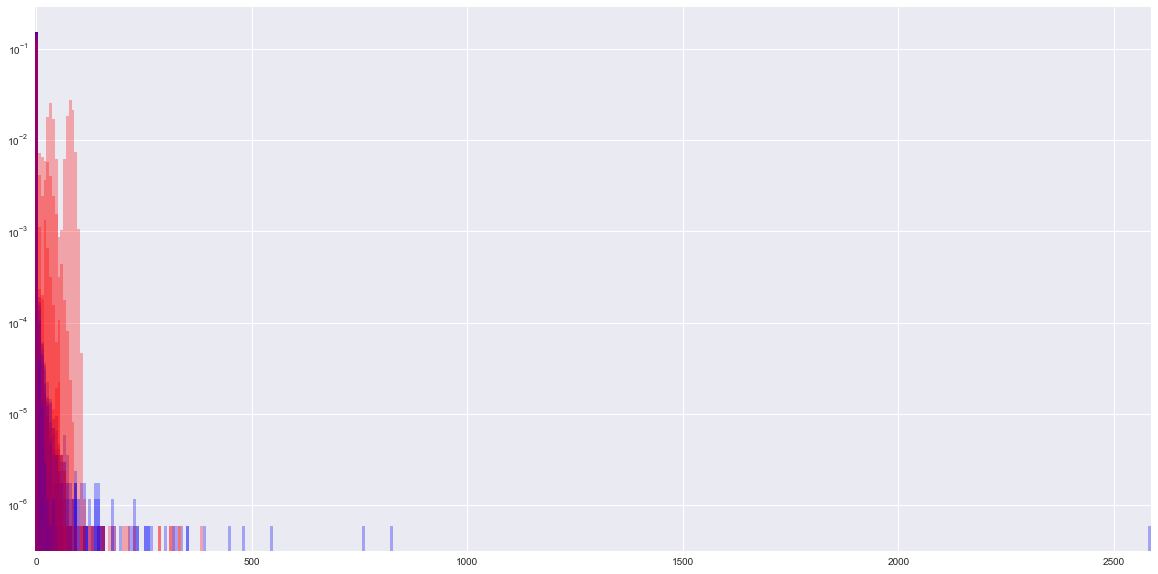

In [35]:
 hist_plot(fake.detach(), real_cpu, True, '.' )

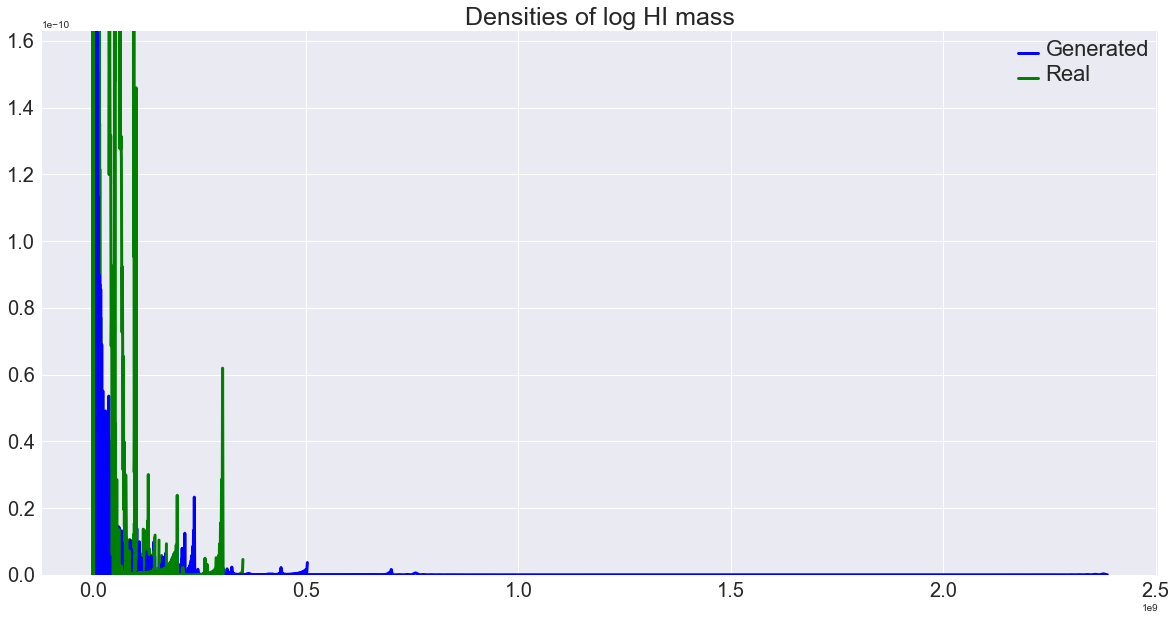

In [33]:
plot_densities(np.array(real_cpu.detach())*std_5+mean_5, np.array(fake*std_5+mean_5), log_=True)

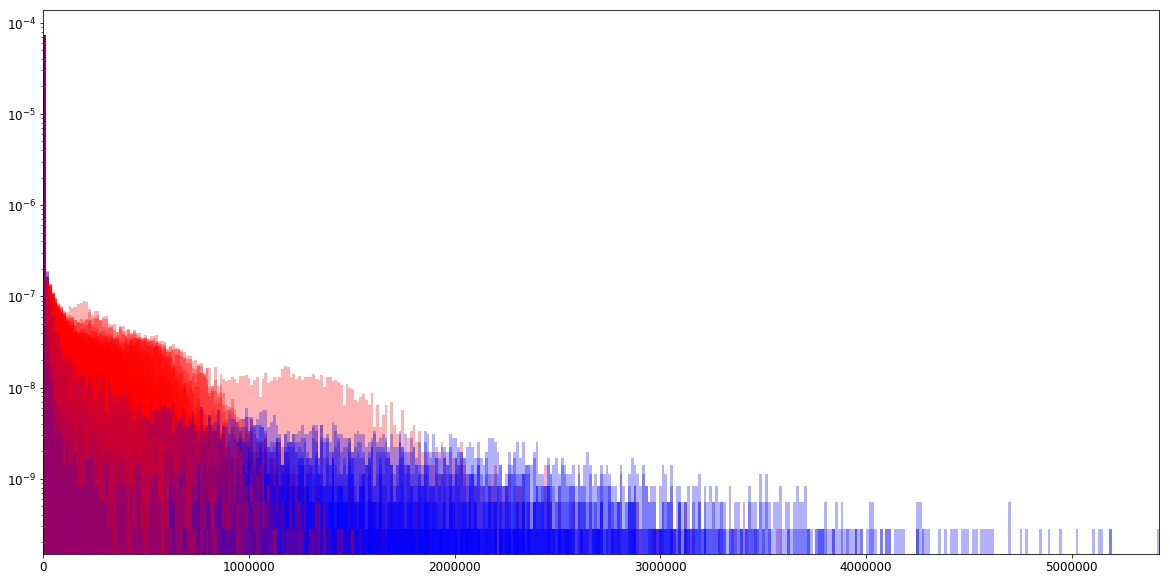

In [32]:
hist_plot(fake.detach()*std_5, real_cpu*std_5, True, '.' )

data_1dim len = 24999
scatter size mean = 100.0
scatter size max = 100.0
scatter size min = 100.0


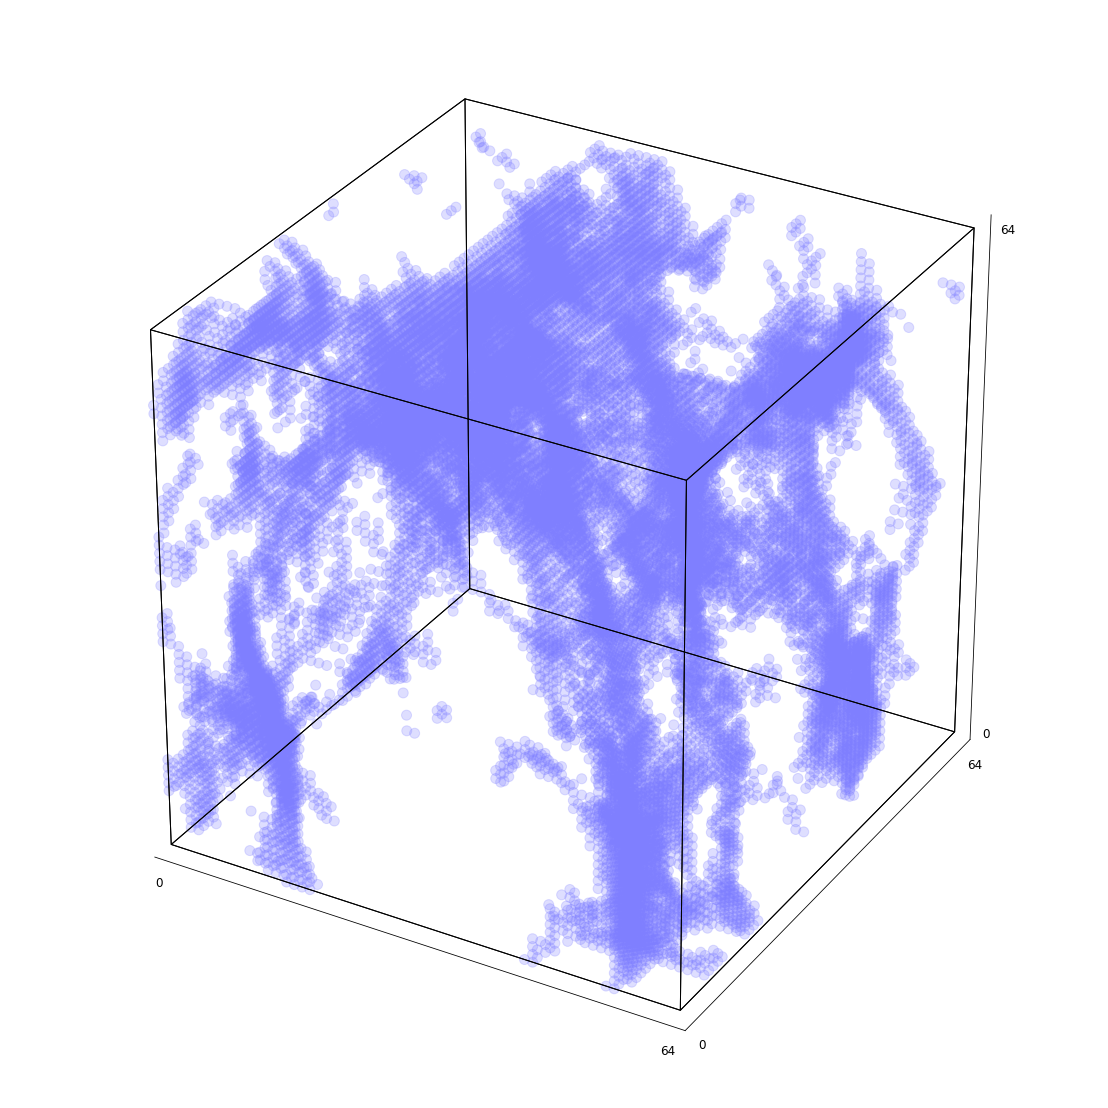

In [53]:
visualize_cube(cube=np.array((real_cpu[m][0].detach())*std_5),      # array name
             edge_dim=s_sample,        # edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=(20,20),
             #stdev_to_white=-3,
             norm_multiply=1e2,
             size_magnitude = False,
             color_map="Blues",
             plot_show = True,
             plot_save = False,
             save_fig = False,
            raw_cube_max =max_5)

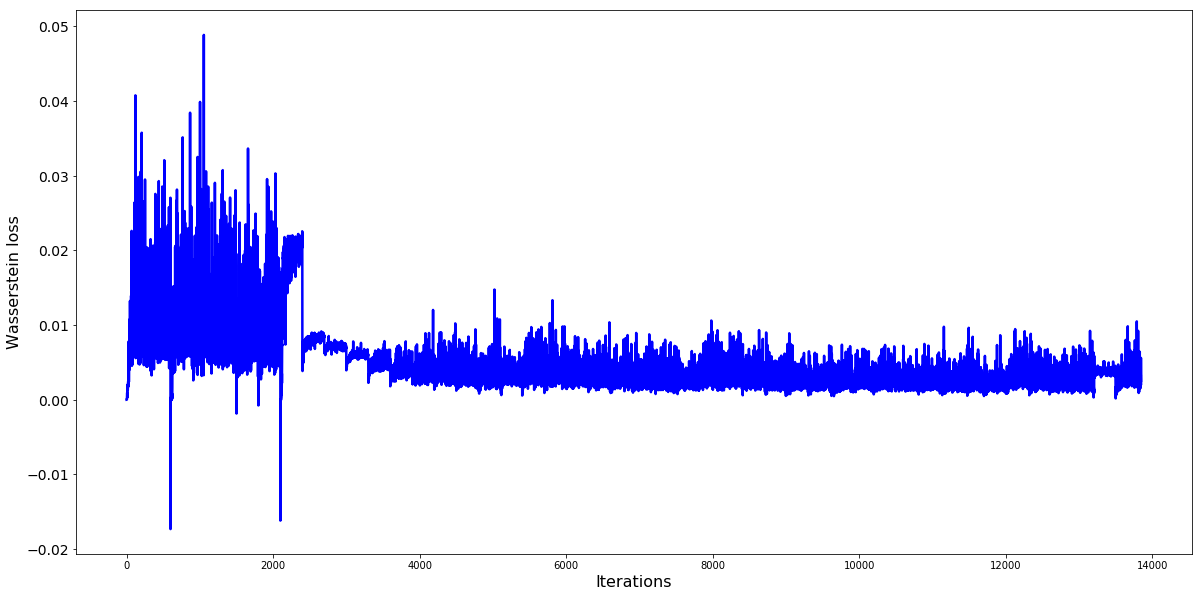

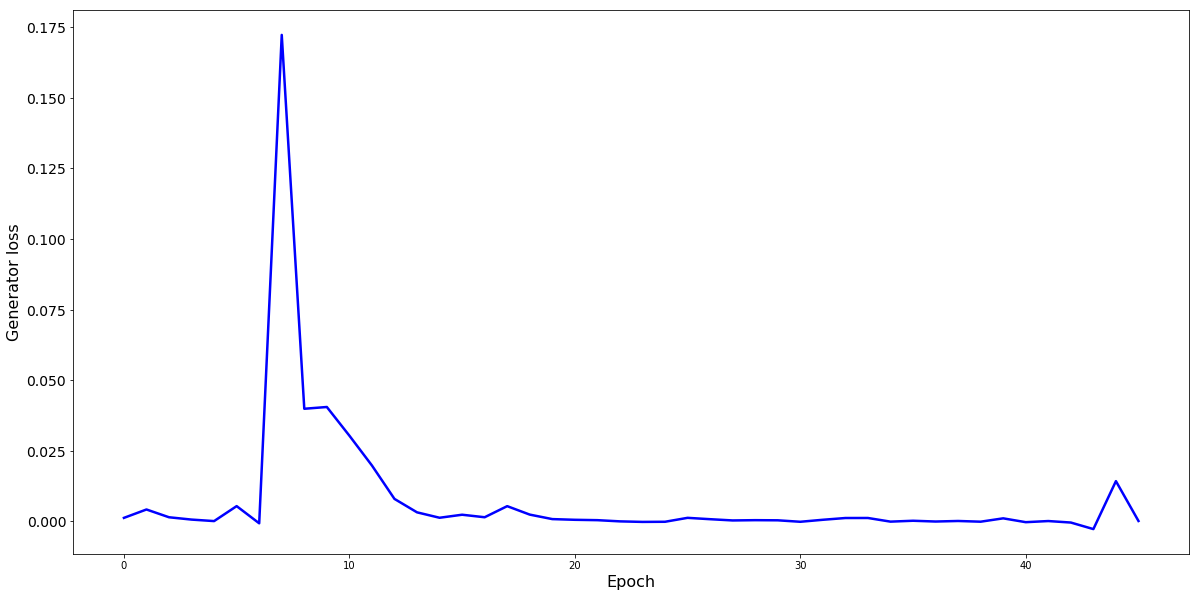

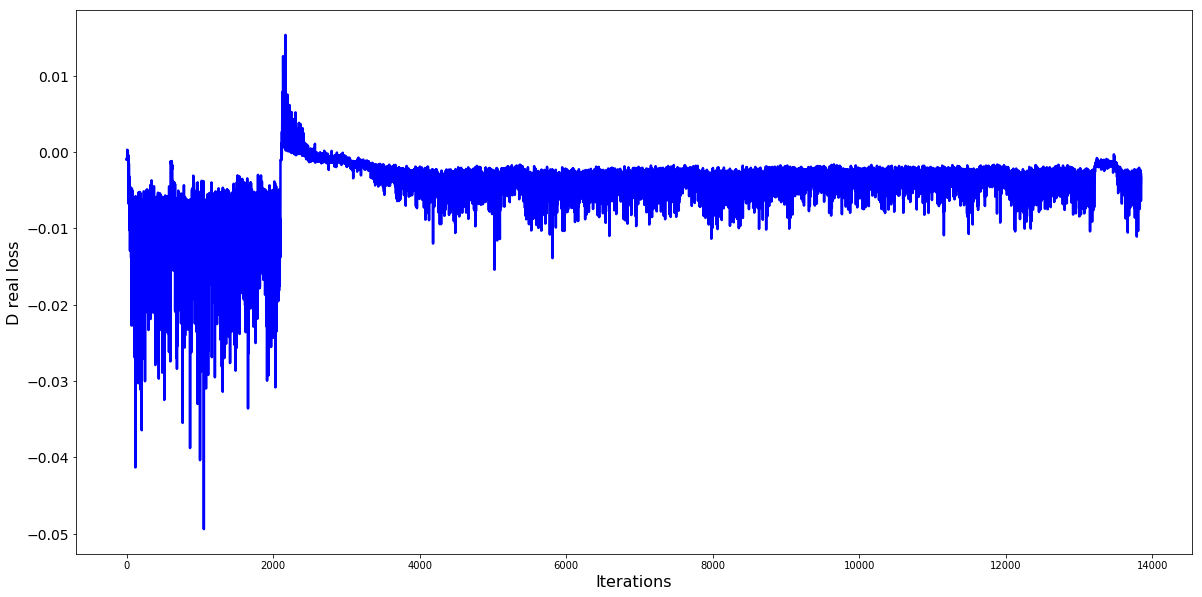

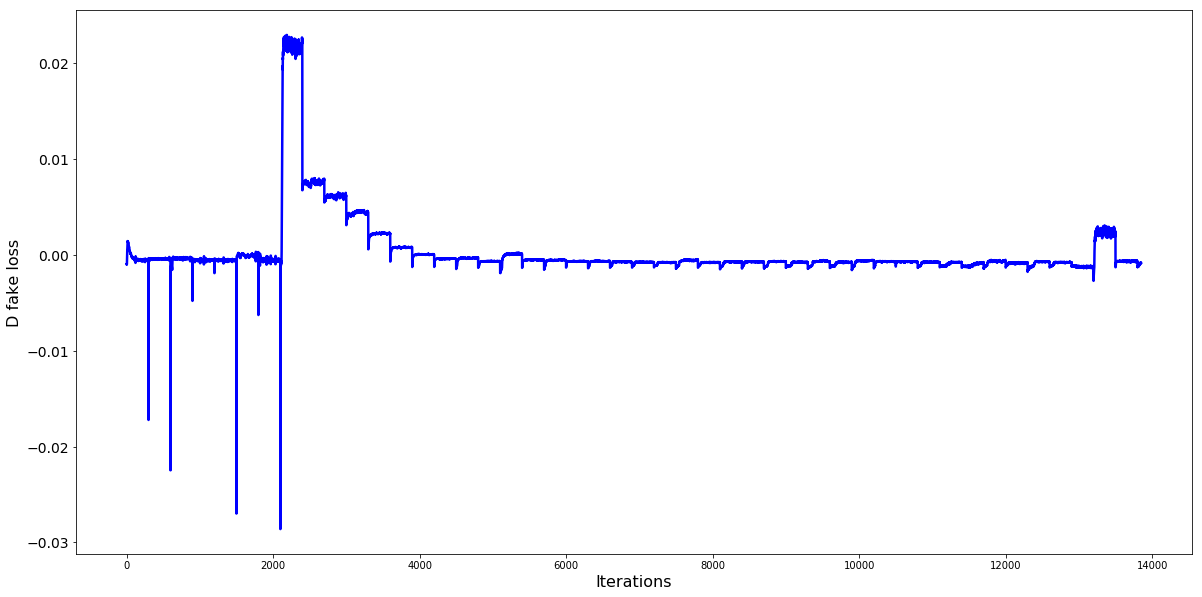

In [15]:
plot_loss(wass_loss,'Wasserstein loss', log_=False)
plot_loss(errG_l,'Generator loss', log_=False)
plot_loss(errD_real_l,'D real loss', log_=False)
plot_loss(errD_fake_l,'D fake loss', log_=False)

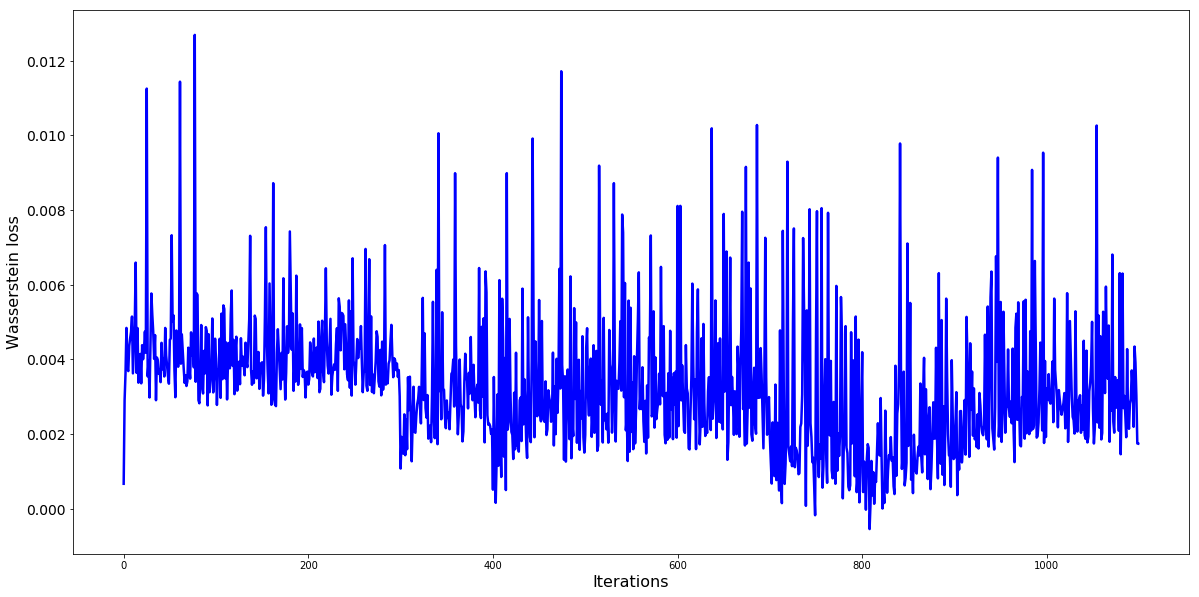

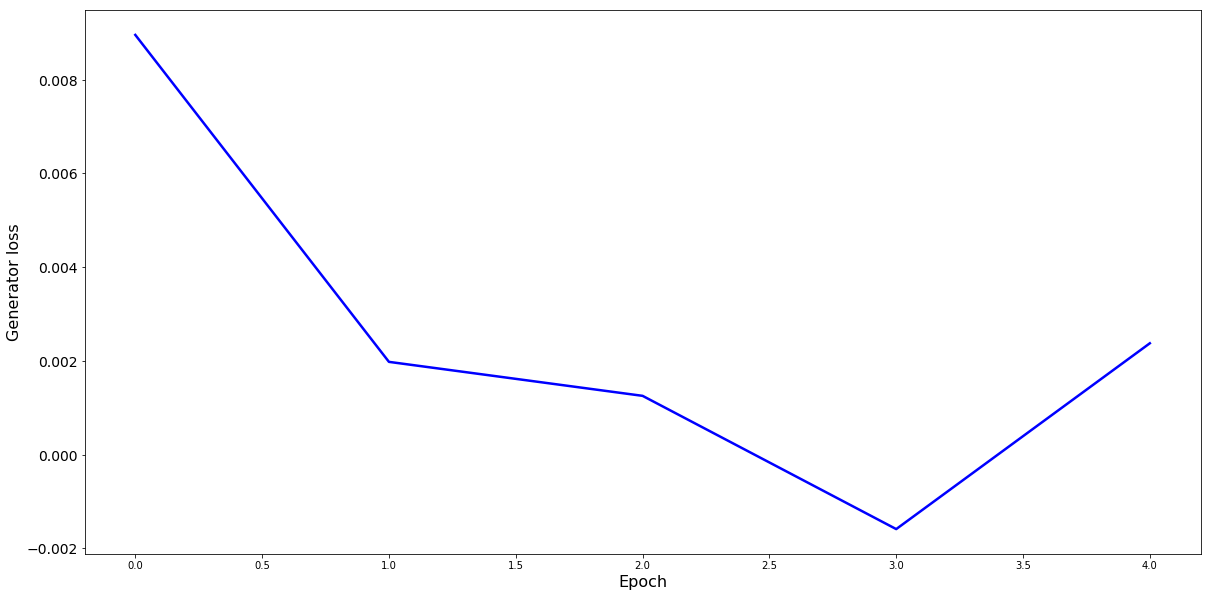

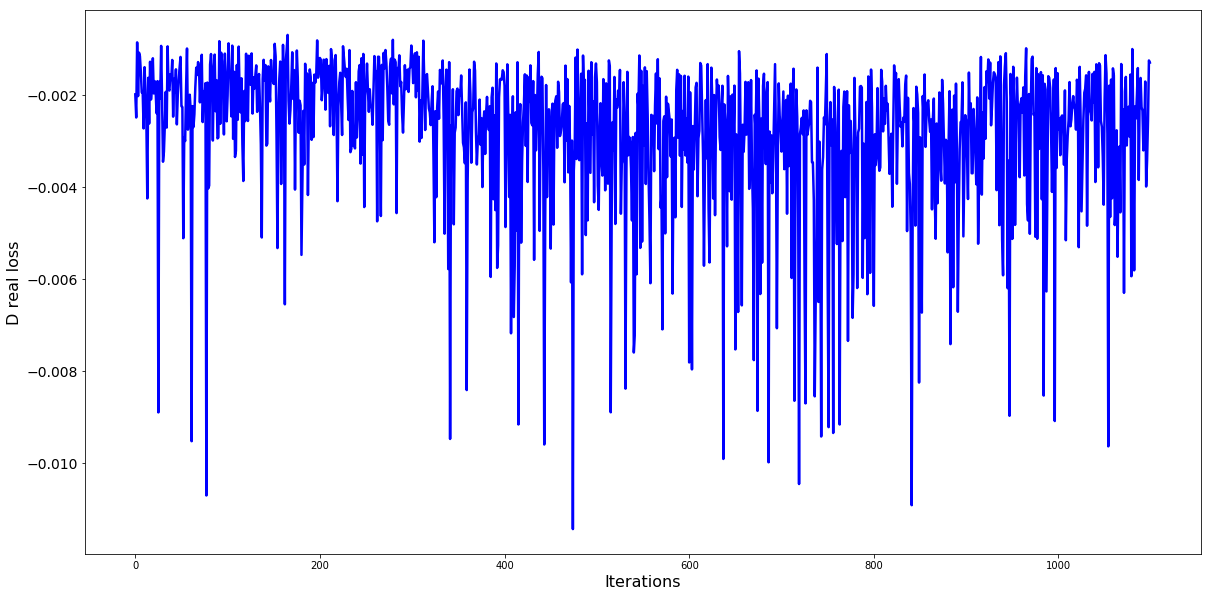

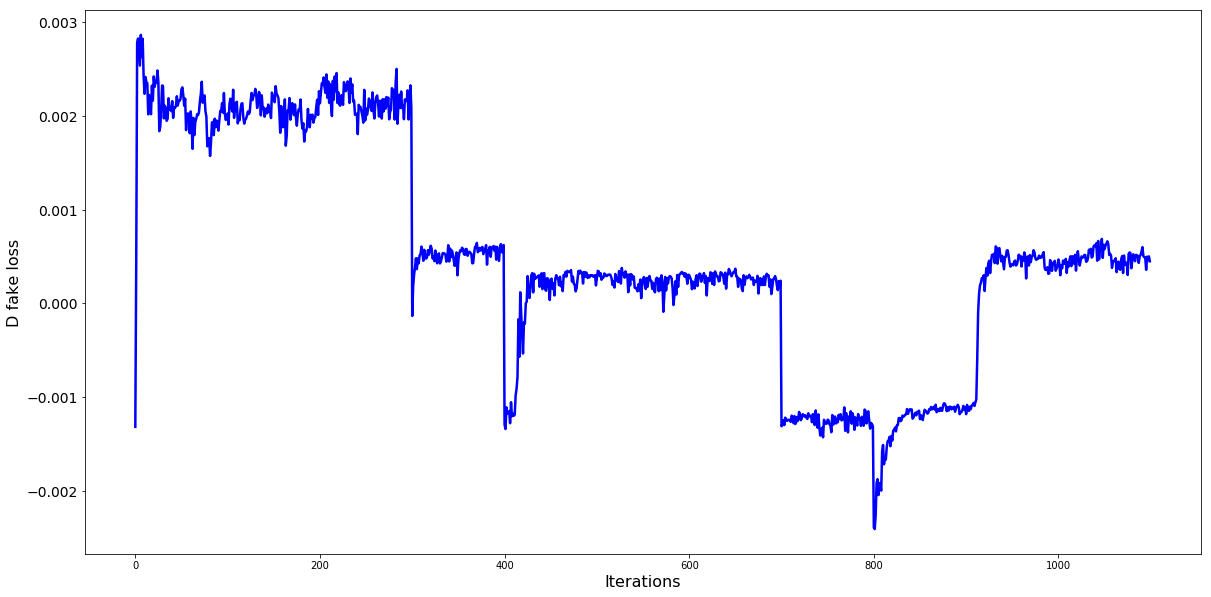

In [19]:
plot_loss(wass_loss,'Wasserstein loss', log_=False)
plot_loss(errG_l,'Generator loss', log_=False)
plot_loss(errD_real_l,'D real loss', log_=False)
plot_loss(errD_fake_l,'D fake loss', log_=False)

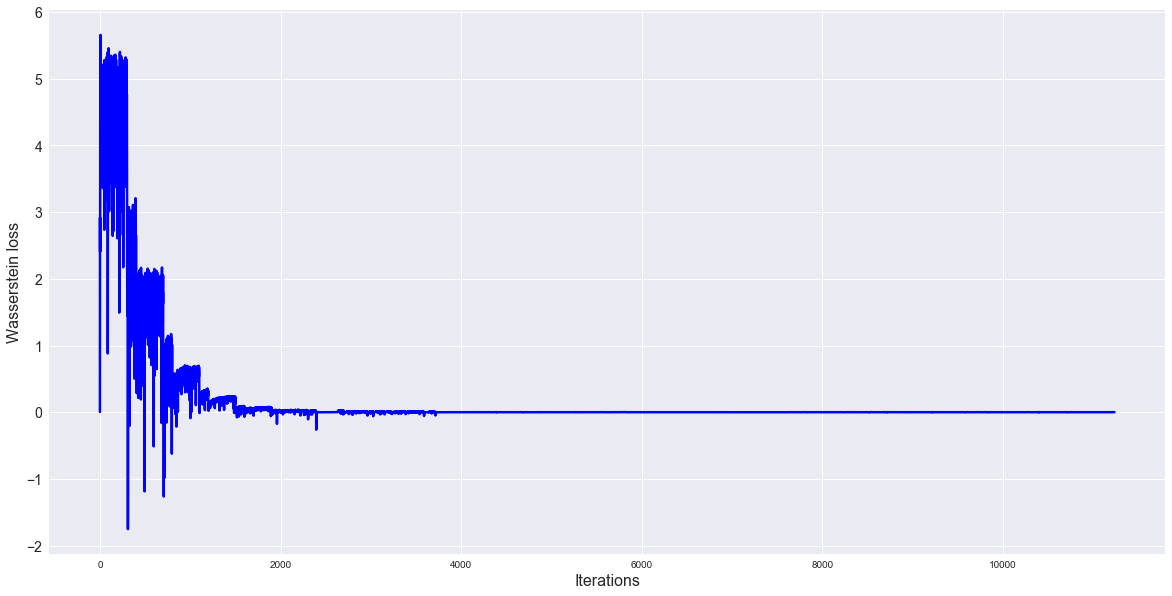

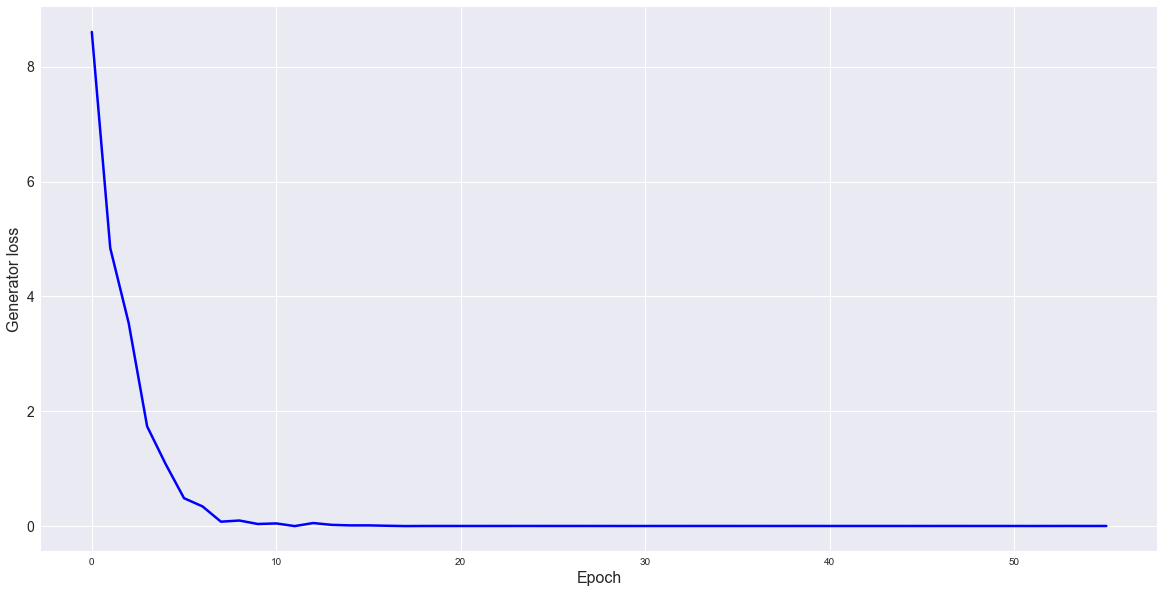

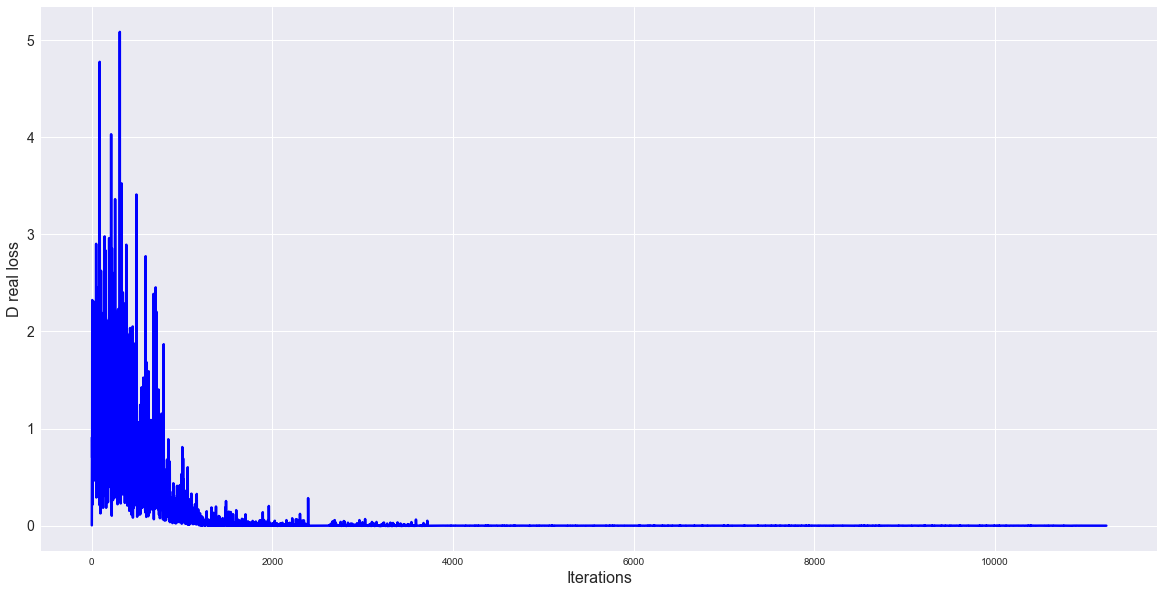

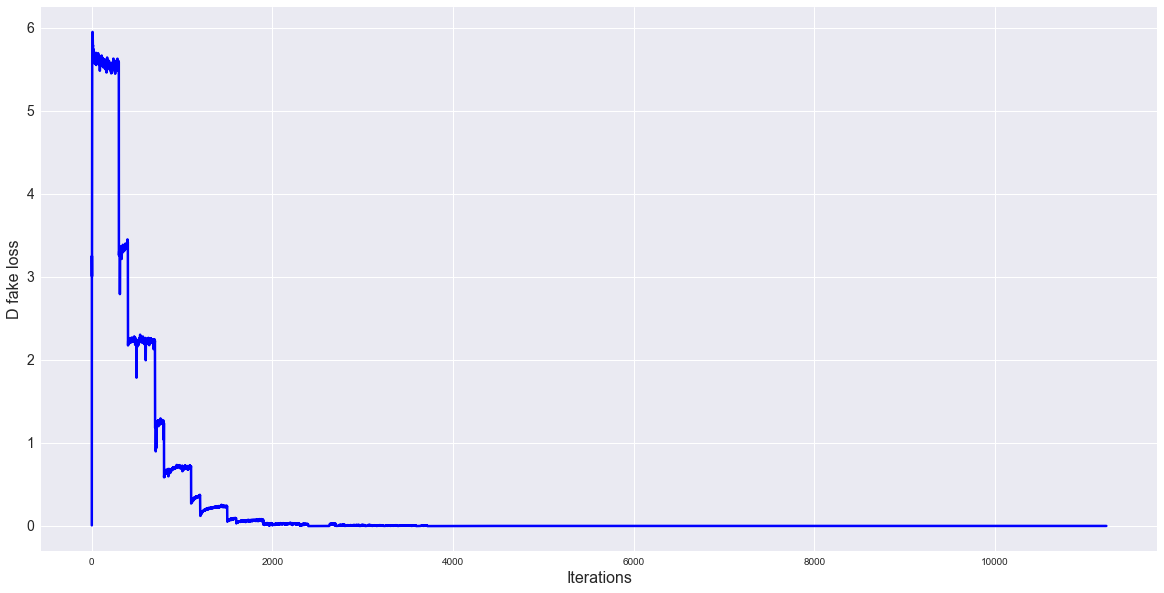

In [24]:
plot_loss(wass_loss,'Wasserstein loss', log_=False)
plot_loss(errG_l,'Generator loss', log_=False)
plot_loss(errD_real_l,'D real loss', log_=False)
plot_loss(errD_fake_l,'D fake loss', log_=False)


In [16]:
#Input minibatches
def plot_mass_hist(fake, real, s_sample, together):
    num_bins=100
    al=0.9
    dens=False
    xlim=.02
    
    plt.figure(figsize=(20,10))
               
    k=0
    for n in  range(fake.shape[0]):
        k+=1
        label='Generated' if k==1 else None
        #plt.hist(np.where(fake[n].reshape(s_sample, s_sample, s_sample).flatten() >0),
        plt.hist(np.where(fake[n].reshape(s_sample, s_sample, s_sample).flatten() > 0),
                alpha=al, bins=num_bins, normed=dens, color='r', label=label)
        
    
    if together==False:
        plt.tick_params(axis='both', which='major', labelsize=18)
        plt.legend(loc='best',fontsize=18)
        plt.xlim(0,xlim)
        plt.show()
        
        plt.figure(figsize=(20,10))
    
    k=0   
    for m in range(real.shape[0]):
        k+=1
        label='Real' if k==1 else None
        plt.hist(np.where(real[m].reshape(s_sample, s_sample, s_sample).flatten() >0),alpha=al,bins=num_bins, 
                 normed=dens ,color='g', label=label)
    
    plt.legend(loc='best',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.title('PDFs of Hydrogen mass', fontsize=18)
        #plt.savefig('speed_hist.jpg',format='jpg', dpi=100)
    #plt.xlim(0,xlim)
    plt.show()

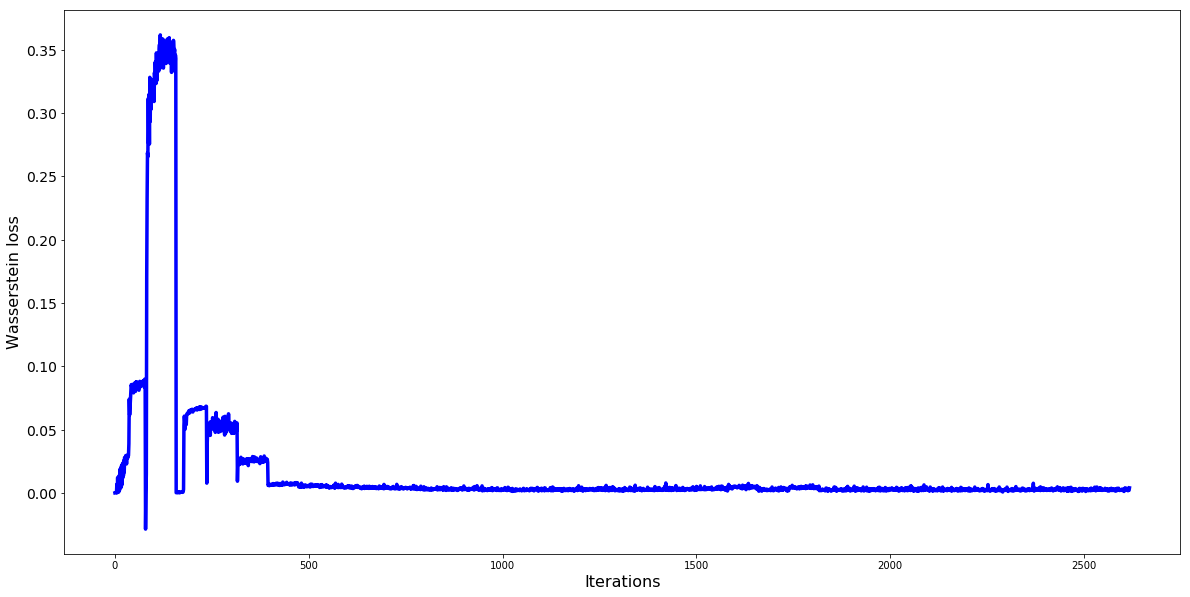

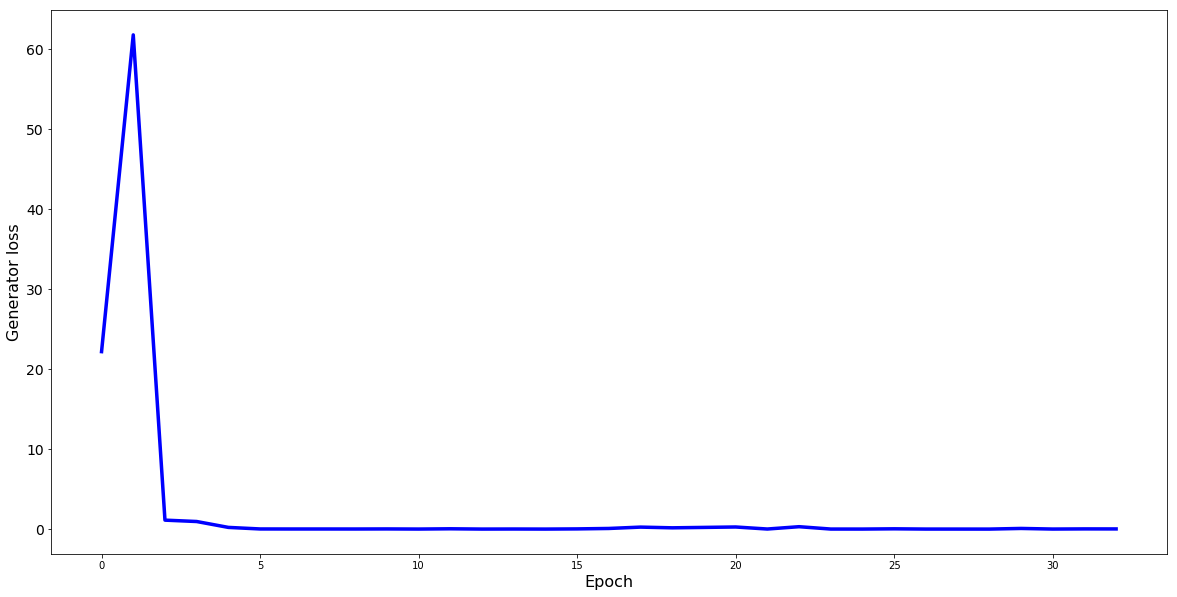

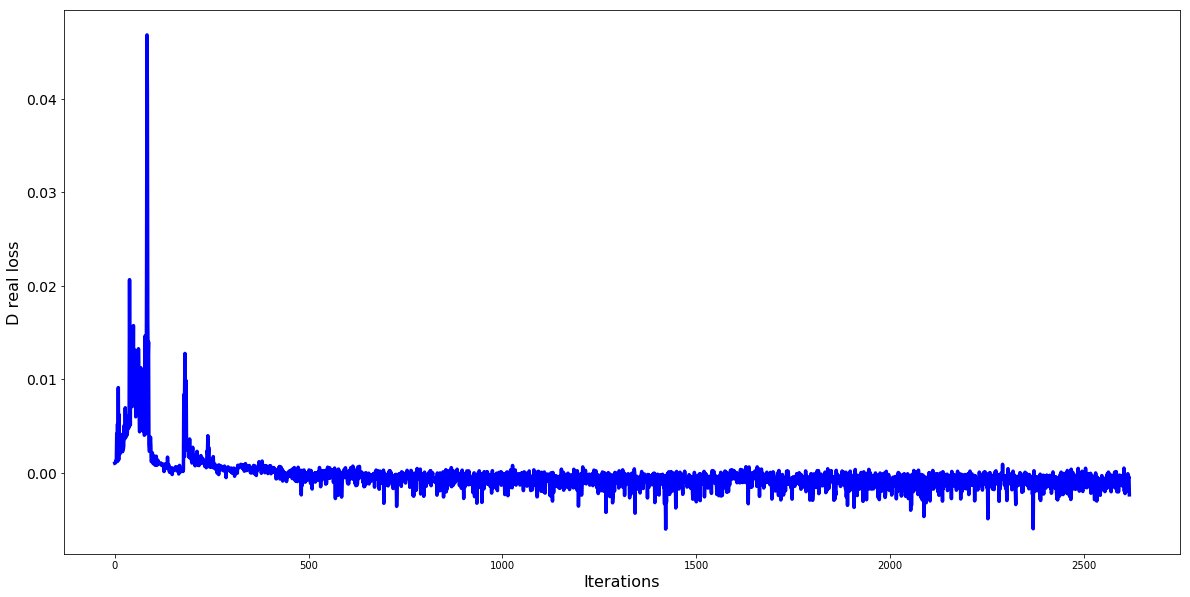

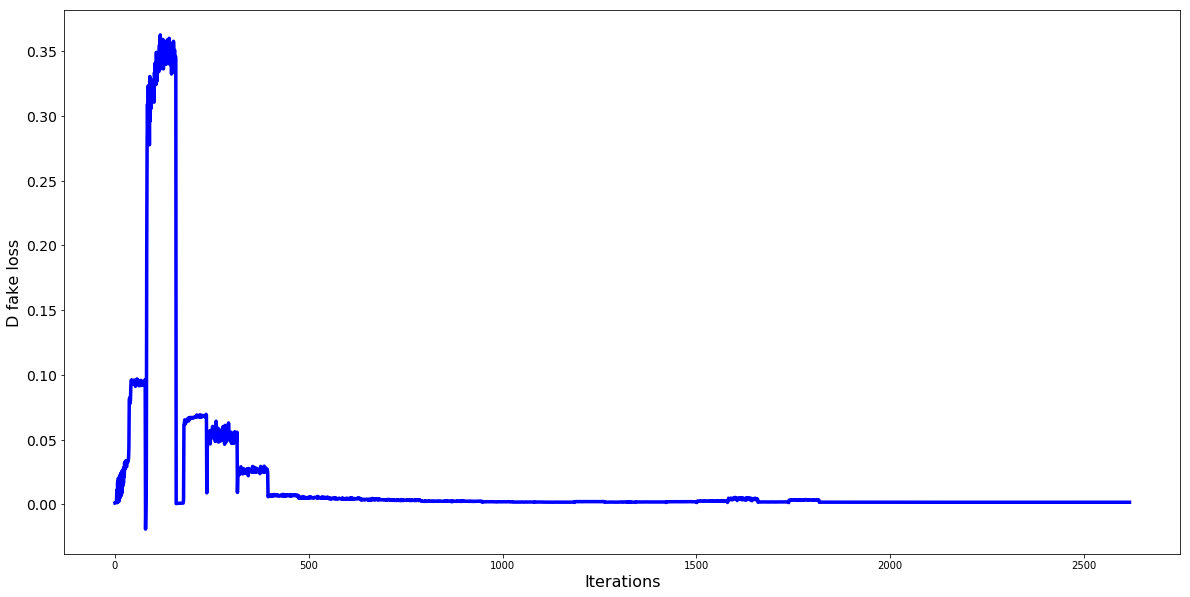

In [18]:
#Previous iteration
plot_loss(wass_loss,'Wasserstein loss', log_=False)
plot_loss(errG_l,'Generator loss', log_=False)
plot_loss(errD_real_l,'D real loss', log_=False)
plot_loss(errD_fake_l,'D fake loss', log_=False)

In [ ]:
plot_mass_hist(np.array(fake[0].view(s_sample,s_sample,s_sample).detach()), np.array(data[0].view(s_sample,s_sample,s_sample).detach()))

In [ ]:
#Atakans architecture

In [8]:
from conv_utils import calculate_conv_output_dim, calculate_pool_output_dim

# input: batch_size * nc * 64 * 64
# output: batch_size * k * 1 * 1
class N_Disc(nn.Module):
    def __init__(self, cube_dimension, fc1_hidden_dim, fc2_output_dim, 
                embedding_dim, leakyrelu_const, pool_return_indices):        
        super(N_Disc, self).__init__()

        self.pool_return_indices = pool_return_indices
      
        # First Convolutional Layer
        self.conv1_in_channels = 1
        self.conv1_out_channels = 2
        self.conv1_kernel = 3
        self.conv1_stride = 1
        self.conv1_padding = 0
        conv1_output_dim = calculate_conv_output_dim(D=cube_dimension,
                                        K=self.conv1_kernel,
                                        P=self.conv1_padding,
                                        S=self.conv1_stride)
        print("Conv1 Output Dimension = " + str(conv1_output_dim))
        self.conv1_encode = nn.Conv3d(in_channels=self.conv1_in_channels, 
                                    out_channels=self.conv1_out_channels, 
                                    kernel_size=self.conv1_kernel, 
                                    stride =self.conv1_stride, 
                                    padding=self.conv1_padding)     
        nn.init.xavier_uniform_(self.conv1_encode.weight)
        self.bn1_encode = nn.BatchNorm3d(num_features = self.conv1_out_channels)
        self.leakyrelu1 = nn.LeakyReLU(leakyrelu_const, inplace=True)

        # First Average Pooling
        self.pool1_kernel = 2
        self.pool1_stride = 2 
        pool1_output_dim = calculate_pool_output_dim(D=conv1_output_dim,
                                                    K=self.pool1_kernel,
                                                    S=self.pool1_stride)
        print("Pool1 Output Dimension = " + str(pool1_output_dim)) 
        self.pool1_encode = nn.MaxPool3d(kernel_size=self.pool1_kernel, 
                                            stride=self.pool1_stride,
                                            return_indices = self.pool_return_indices)

        # Second Convolutional Layer
        self.conv2_in_channels = self.conv1_out_channels
        self.conv2_out_channels = 12
        self.conv2_kernel = 4
        self.conv2_stride = 1
        self.conv2_padding = 0
        conv2_output_dim = calculate_conv_output_dim(D=pool1_output_dim,
                                        K=self.conv2_kernel,
                                        P=self.conv2_padding,
                                        S=self.conv2_stride)
        print("Conv2 Output Dimension= " + str(conv2_output_dim))
        self.conv2_encode = nn.Conv3d(in_channels=self.conv2_in_channels, 
                                    out_channels=self.conv2_out_channels, 
                                    kernel_size=self.conv2_kernel, 
                                    stride =self.conv2_stride, 
                                    padding=self.conv2_padding)     
        nn.init.xavier_uniform_(self.conv2_encode.weight)  
        self.bn2_encode = nn.BatchNorm3d(num_features = self.conv2_out_channels)
        self.leakyrelu2 = nn.LeakyReLU(leakyrelu_const, inplace=True)

        # Second Average Pooling
        self.pool2_kernel = 2
        self.pool2_stride = 2 
        pool2_output_dim = calculate_pool_output_dim(D=conv2_output_dim,
                                                K=self.pool2_kernel,
                                                S=self.pool2_stride)
        print("Pool2 Output Dimension = " + str(pool2_output_dim)) 
        self.pool2_encode = nn.MaxPool3d(kernel_size=self.pool2_kernel, 
                                            stride=self.pool2_stride,
                                            return_indices = self.pool_return_indices)   

        # Third Convolutional Layer
        self.conv3_in_channels = self.conv2_out_channels
        self.conv3_out_channels = 24
        self.conv3_kernel = 3
        self.conv3_stride = 1
        self.conv3_padding = 0
        conv3_output_dim = calculate_conv_output_dim(D=pool2_output_dim,
                                        K=self.conv3_kernel,
                                        P=self.conv3_padding,
                                        S=self.conv3_stride)
        print("Conv3 Output Dimension= " + str(conv3_output_dim))
        self.conv3_encode = nn.Conv3d(in_channels=self.conv3_in_channels, 
                                    out_channels=self.conv3_out_channels, 
                                    kernel_size=self.conv3_kernel, 
                                    stride =self.conv3_stride, 
                                    padding=self.conv3_padding)     
        nn.init.xavier_uniform_(self.conv3_encode.weight)
        self.bn3_encode = nn.BatchNorm3d(num_features = self.conv3_out_channels)
        self.leakyrelu3 = nn.LeakyReLU(leakyrelu_const, inplace=True)  

        # Third Average Pooling
        self.pool3_kernel = 2
        self.pool3_stride = 2 
        pool3_output_dim = calculate_pool_output_dim(D=conv3_output_dim,
                                                K=self.pool3_kernel,
                                                S=self.pool3_stride)
        print("Pool3 Output Dimension = " + str(pool3_output_dim)) 
        self.pool3_encode = nn.MaxPool3d(kernel_size=self.pool3_kernel, 
                                            stride=self.pool3_stride,
                                            return_indices = self.pool_return_indices)  

        # Fourth Convolutional Layer
        self.conv4_in_channels = self.conv3_out_channels
        self.conv4_out_channels = 32
        self.conv4_kernel = 4
        self.conv4_stride = 2
        self.conv4_padding = 0
        conv4_output_dim = calculate_conv_output_dim(D=pool3_output_dim,
                                        K=self.conv4_kernel,
                                        P=self.conv4_padding,
                                        S=self.conv4_stride)
        print("Conv4 Output Dimension= " + str(conv4_output_dim))
        self.conv4_encode = nn.Conv3d(in_channels=self.conv4_in_channels, 
                                    out_channels=self.conv4_out_channels, 
                                    kernel_size=self.conv4_kernel, 
                                    stride =self.conv4_stride, 
                                    padding=self.conv4_padding)     
        nn.init.xavier_uniform_(self.conv4_encode.weight) 
        self.bn4_encode = nn.BatchNorm3d(num_features = self.conv4_out_channels)
        self.leakyrelu4 = nn.LeakyReLU(leakyrelu_const, inplace=True)       

        # Fifth Convolutional Layer
        self.conv5_in_channels = self.conv4_out_channels
        self.conv5_out_channels = 64
        self.conv5_kernel = 3
        self.conv5_stride = 1
        self.conv5_padding = 0
        conv5_output_dim = calculate_conv_output_dim(D=conv4_output_dim,
                                        K=self.conv5_kernel,
                                        P=self.conv5_padding,
                                        S=self.conv5_stride)
        print("Conv5 Output Dimension= " + str(conv5_output_dim))
        self.conv5_encode = nn.Conv3d(in_channels=self.conv5_in_channels, 
                                    out_channels=self.conv5_out_channels, 
                                    kernel_size=self.conv5_kernel, 
                                    stride =self.conv5_stride, 
                                    padding=self.conv5_padding)     
        nn.init.xavier_uniform_(self.conv5_encode.weight) 
        self.bn5_encode = nn.BatchNorm3d(num_features = self.conv5_out_channels)
        self.leakyrelu5 = nn.LeakyReLU(leakyrelu_const, inplace=True)

        # Sixth Convolutional Layer
        self.conv6_in_channels = self.conv5_out_channels
        self.conv6_out_channels = 128
        self.conv6_kernel = 2
        self.conv6_stride = 1
        self.conv6_padding = 0
        conv6_output_dim = calculate_conv_output_dim(D=conv5_output_dim,
                                        K=self.conv6_kernel,
                                        P=self.conv6_padding,
                                        S=self.conv6_stride)
        print("Conv6 Output Dimension= " + str(conv6_output_dim))
        self.conv6_encode = nn.Conv3d(in_channels=self.conv6_in_channels, 
                                    out_channels=self.conv6_out_channels, 
                                    kernel_size=self.conv6_kernel, 
                                    stride =self.conv6_stride, 
                                    padding=self.conv6_padding)     
        nn.init.xavier_uniform_(self.conv6_encode.weight) 
        self.bn6_encode = nn.BatchNorm3d(num_features = self.conv6_out_channels)
        self.leakyrelu6 = nn.LeakyReLU(leakyrelu_const, inplace=True)

        # 7th Convolutional Layer
        self.conv7_in_channels = self.conv6_out_channels
        self.conv7_out_channels = 1
        self.conv7_kernel = 2
        self.conv7_stride = 2
        self.conv7_padding = 0
        conv7_output_dim = calculate_conv_output_dim(D=conv6_output_dim,
                                        K=self.conv7_kernel,
                                        P=self.conv7_padding,
                                        S=self.conv7_stride)
        print("Conv7 Output Dimension= " + str(conv7_output_dim))
        
        self.conv7_encode = nn.Conv3d(in_channels=self.conv7_in_channels, 
                                    out_channels=self.conv7_out_channels, 
                                    kernel_size=self.conv7_kernel, 
                                    stride =self.conv7_stride, 
                                    padding=self.conv7_padding)     
        
        nn.init.xavier_uniform_(self.conv7_encode.weight) 
        #self.bn7_encode = nn.BatchNorm3d(num_features = self.conv7_out_channels)
        
        #self.leakyrelu7 = nn.LeakyReLU(leakyrelu_const, inplace=True)
     
    #         # 1st FC Layer
#         self.fc1_in_features = self.conv7_out_channels * conv7_output_dim**3
#         self.fc1_encode = nn.Linear(in_features=self.fc1_in_features,
#                                     out_features=fc1_hidden_dim)
#         self.leakyrelu8 = nn.LeakyReLU(leakyrelu_const, inplace=True)

#         # 2nd FC Layer
#         self.fc2_encode = nn.Linear(in_features=self.fc1_hidden_dim,
#                                     out_features=embedding_dim)
#         self.relu1 = nn.ReLU(inplace=True)

    def forward(self, input):
        
        # Convolution Layers
#         print("Input = " +str(input.shape))
        out = self.conv1_encode(input)
#         print("conv1_encode = " + str(out.shape))
        out = self.pool1_encode(out)
#         print("pool1_encode = " + str(out.shape))
        out = self.bn1_encode(out) 
        out = self.leakyrelu1(out)

        out = self.conv2_encode(out)
#         print("conv2_encode = " + str(out.shape))
        out = self.pool2_encode(out)
#         print("pool2_encode = " + str(out.shape))
        out = self.bn2_encode(out) 
        out = self.leakyrelu2(out)

        out = self.conv3_encode(out)
#         print("conv3_encode = " + str(out.shape))
        out = self.pool3_encode(out)
#         print("pool3_encode = " + str(out.shape))
        out = self.bn3_encode(out) 
        out = self.leakyrelu3(out)

        out = self.conv4_encode(out)
#         print("conv4_encode = " + str(out.shape))
        out = self.bn4_encode(out) 
        out = self.leakyrelu4(out)

        out = self.conv5_encode(out)
#         print("conv5_encode = " + str(out.shape))
        out = self.bn5_encode(out) 
        out = self.leakyrelu5(out)

        out = self.conv6_encode(out)
#         print("conv6_encode = " + str(out.shape))
        out = self.bn6_encode(out) 
        out = self.leakyrelu6(out)
        
        out = self.conv7_encode(out)
#         print("conv7_encode = " + str(out.shape))
        #out = self.bn7_encode(out) 
        #out = self.leakyrelu7(out)
        
#         print("out = " + str(out.shape))

#         # Transform
        print('D last', out.shape)
        

        #out = out.view(batchSize, -1)

#         # FC Layers
#         out = self.fc1_encode(out)
#         out = self.leakyrelu8(out)

#         out = self.fc2_encode(out)
#         out = self.relu1(out)        
        out= out.mean(0)
        return out.view(1)

In [20]:
from conv_utils import calculate_deconv_output_dim

# input: batch_size * k * 1 * 1
# output: batch_size * nc * image_size * image_size
class N_Gen(nn.Module):
    def __init__(self, embedded_cube_dimension,fc1_hidden_dim, fc2_output_dim, 
                embedding_dim, leakyrelu_const):
        super(N_Gen, self).__init__()

#         # 1st FC Layer
#         self.embedding_dim = embedding_dim
#         self.fc1_in_features = self.embedding_dim 
#         self.fc1_hidden_dim = fc1_hidden_dim
#         self.fc1_decode = nn.Linear(in_features=self.fc1_in_features,
#                                     out_features=self.fc1_hidden_dim)
#         self.leakyrelu1 = nn.LeakyReLU(leakyrelu_const, inplace=True)

#         # 2nd FC Layer
#         self.fc2_output_dim = fc2_output_dim
#         self.fc2_decode = nn.Linear(in_features=self.fc1_hidden_dim,
#                                     out_features=self.fc2_output_dim )
#         self.leakyrelu2 = nn.LeakyReLU(leakyrelu_const, inplace=True)

        # 1st Deconvolutional Layer
        self.deconv1_in_channels = batch_size
        self.deconv1_out_channels = 128
        self.deconv1_kernel = 2
        self.deconv1_stride = 1
        self.deconv1_padding = 0
        deconv1_output_dim = calculate_deconv_output_dim(D=embedded_cube_dimension,
                                        K=self.deconv1_kernel,
                                        P=self.deconv1_padding,
                                        S=self.deconv1_stride)
        print("Deconv1 Output Dimension = " + str(deconv1_output_dim))
        self.deconv1_decode = nn.ConvTranspose3d(in_channels=self.deconv1_in_channels, 
                                    out_channels=self.deconv1_out_channels, 
                                    kernel_size=self.deconv1_kernel, 
                                    stride =self.deconv1_stride, 
                                    padding=self.deconv1_padding)     
        nn.init.xavier_uniform_(self.deconv1_decode.weight)
        self.bn1_decode = nn.BatchNorm3d(num_features = self.deconv1_out_channels)
        self.leakyrelu1 = nn.LeakyReLU(leakyrelu_const, inplace=True)

        # 2nd Deconvolutional Layer
        self.deconv2_in_channels = self.deconv1_out_channels
        self.deconv2_out_channels = 64
        self.deconv2_kernel = 2
        self.deconv2_stride = 1
        self.deconv2_padding = 0
        deconv2_output_dim = calculate_deconv_output_dim(D=deconv1_output_dim,
                                        K=self.deconv2_kernel,
                                        P=self.deconv2_padding,
                                        S=self.deconv2_stride)
        print("Deconv2 Output Dimension = " + str(deconv2_output_dim))
        self.deconv2_decode = nn.ConvTranspose3d(in_channels=self.deconv2_in_channels, 
                                    out_channels=self.deconv2_out_channels, 
                                    kernel_size=self.deconv2_kernel, 
                                    stride =self.deconv2_stride, 
                                    padding=self.deconv2_padding)     
        nn.init.xavier_uniform_(self.deconv2_decode.weight)
        self.bn2_decode = nn.BatchNorm3d(num_features = self.deconv2_out_channels)
        self.leakyrelu2 = nn.LeakyReLU(leakyrelu_const, inplace=True)
        
        # 3rd Deconvolutional Layer
        self.deconv3_in_channels = self.deconv2_out_channels
        self.deconv3_out_channels = 32
        self.deconv3_kernel = 3
        self.deconv3_stride = 1
        self.deconv3_padding = 0
        deconv3_output_dim = calculate_deconv_output_dim(D=deconv2_output_dim,
                                        K=self.deconv3_kernel,
                                        P=self.deconv3_padding,
                                        S=self.deconv3_stride)
        print("Deconv3 Output Dimension = " + str(deconv3_output_dim))
        self.deconv3_decode = nn.ConvTranspose3d(in_channels=self.deconv3_in_channels, 
                                    out_channels=self.deconv3_out_channels, 
                                    kernel_size=self.deconv3_kernel, 
                                    stride =self.deconv3_stride, 
                                    padding=self.deconv3_padding)     
        nn.init.xavier_uniform_(self.deconv3_decode.weight)
        self.bn3_decode = nn.BatchNorm3d(num_features = self.deconv3_out_channels)
        self.leakyrelu3 = nn.LeakyReLU(leakyrelu_const, inplace=True)
        
        # 4th Deconvolutional Layer
        self.deconv4_in_channels = self.deconv3_out_channels
        self.deconv4_out_channels = 24
        self.deconv4_kernel = 4
        self.deconv4_stride = 2
        self.deconv4_padding = 0
        deconv4_output_dim = calculate_deconv_output_dim(D=deconv3_output_dim,
                                        K=self.deconv4_kernel,
                                        P=self.deconv4_padding,
                                        S=self.deconv4_stride)
        print("Deconv4 Output Dimension = " + str(deconv4_output_dim))
        self.deconv4_decode = nn.ConvTranspose3d(in_channels=self.deconv4_in_channels, 
                                    out_channels=self.deconv4_out_channels, 
                                    kernel_size=self.deconv4_kernel, 
                                    stride =self.deconv4_stride, 
                                    padding=self.deconv4_padding)     
        nn.init.xavier_uniform_(self.deconv4_decode.weight)
        self.bn4_decode = nn.BatchNorm3d(num_features = self.deconv4_out_channels)
        self.leakyrelu4 = nn.LeakyReLU(leakyrelu_const, inplace=True)
        
        # Avg Unpooling 1
        # Just make 1 voxel to 8 voxels of 2-len edges
        # Implemented in forward pass
        self.avgunpool1_scale = 2
        self.avgunpool1 = nn.Upsample(scale_factor = self.avgunpool1_scale, mode='nearest')
        
        
        # 5th Deconvolutional Layer
        self.deconv5_in_channels = self.deconv4_out_channels
        self.deconv5_out_channels = 12
        self.deconv5_kernel = 3
        self.deconv5_stride = 1
        self.deconv5_padding = 0
        deconv5_output_dim = calculate_deconv_output_dim(D=deconv4_output_dim * self.avgunpool1_scale,
                                        K=self.deconv5_kernel,
                                        P=self.deconv5_padding,
                                        S=self.deconv5_stride)
        print("Deconv5 Output Dimension = " + str(deconv5_output_dim))
        self.deconv5_decode = nn.ConvTranspose3d(in_channels=self.deconv5_in_channels, 
                                    out_channels=self.deconv5_out_channels, 
                                    kernel_size=self.deconv5_kernel, 
                                    stride =self.deconv5_stride, 
                                    padding=self.deconv5_padding)     
        nn.init.xavier_uniform_(self.deconv5_decode.weight)
        self.bn5_decode = nn.BatchNorm3d(num_features = self.deconv5_out_channels)
        self.leakyrelu5 = nn.LeakyReLU(leakyrelu_const, inplace=True)
        
        # Avg Unpooling 2
        # Just make 1 voxel to 8 voxels of 2-len edges
        # Implemented in forward pass
        self.avgunpool2_scale = 2
        self.avgunpool2 = nn.Upsample(scale_factor = self.avgunpool2_scale, mode='nearest')
        
        # 6th Deconvolutional Layer
        self.deconv6_in_channels = self.deconv5_out_channels
        self.deconv6_out_channels = 2
        self.deconv6_kernel = 4
        self.deconv6_stride = 1
        self.deconv6_padding = 0
        deconv6_output_dim = calculate_deconv_output_dim(D=deconv5_output_dim * self.avgunpool2_scale,
                                        K=self.deconv6_kernel,
                                        P=self.deconv6_padding,
                                        S=self.deconv6_stride)
        print("Deconv6 Output Dimension = " + str(deconv6_output_dim))
        self.deconv6_decode = nn.ConvTranspose3d(in_channels=self.deconv6_in_channels, 
                                    out_channels=self.deconv6_out_channels, 
                                    kernel_size=self.deconv6_kernel, 
                                    stride =self.deconv6_stride, 
                                    padding=self.deconv6_padding)     
        nn.init.xavier_uniform_(self.deconv6_decode.weight)
        self.bn6_decode = nn.BatchNorm3d(num_features = self.deconv6_out_channels)
        self.leakyrelu6 = nn.LeakyReLU(leakyrelu_const, inplace=True)
        
        # Avg Unpooling 3
        # Just make 1 voxel to 8 voxels of 2-len edges
        # Implemented in forward pass
        self.avgunpool3_scale = 2
        self.avgunpool3 = nn.Upsample(scale_factor = self.avgunpool3_scale, mode='nearest')
        
        # 7th Deconvolutional Layer
        self.deconv7_in_channels = self.deconv6_out_channels
        self.deconv7_out_channels = 1
        self.deconv7_kernel = 3
        self.deconv7_stride = 1
        self.deconv7_padding = 0
        deconv7_output_dim = calculate_deconv_output_dim(D=deconv6_output_dim * self.avgunpool3_scale,
                                        K=self.deconv7_kernel,
                                        P=self.deconv7_padding,
                                        S=self.deconv7_stride)
        print("Deconv7 Output Dimension = " + str(deconv7_output_dim))
        self.deconv7_decode = nn.ConvTranspose3d(in_channels=self.deconv7_in_channels, 
                                    out_channels=self.deconv7_out_channels, 
                                    kernel_size=self.deconv7_kernel, 
                                    stride =self.deconv7_stride, 
                                    padding=self.deconv7_padding)     
        nn.init.xavier_uniform_(self.deconv7_decode.weight)
        self.bn7_decode = nn.BatchNorm3d(num_features = self.deconv7_out_channels)
#         self.leakyrelu7 = nn.LeakyReLU(leakyrelu_const, inplace=True)
        
        # For data in [0,1]
#         self.relu7 = nn.ReLU(inplace=True)     
        # For data in [-1,1]
        self.tanh7 = nn.Tanh()     

    def forward(self, input):
#         print("\nDecoder - Forward Pass")
        
        # Deconvolution Layers
#         print("Input = " +str(input.shape))
        out = self.deconv1_decode(input)
#         print("deconv1_decode = " + str(out.shape))
        out = self.bn1_decode(out)
        out = self.leakyrelu1(out)

        out = self.deconv2_decode(out)
#         print("deconv2_decode = " + str(out.shape))
        out = self.bn2_decode(out)
        out = self.leakyrelu2(out)
        
        out = self.deconv3_decode(out)
#         print("deconv3_decode = " + str(out.shape))
        out = self.bn3_decode(out)
        out = self.leakyrelu3(out)
        
        out = self.deconv4_decode(out)
#         print("deconv4_decode = " + str(out.shape))
        out = self.bn4_decode(out)
        out = self.leakyrelu4(out)
        out = self.avgunpool1(out)
#         print("avgunpool1 = " + str(out.shape))

        out = self.deconv5_decode(out)
#         print("deconv5_decode = " + str(out.shape))
        out = self.bn5_decode(out)
        out = self.leakyrelu5(out)
        out = self.avgunpool2(out)
#         print("avgunpool2 = " + str(out.shape))
        out = self.deconv6_decode(out)
#         print("deconv6_decode = " + str(out.shape))
        out = self.bn6_decode(out)
        out = self.leakyrelu6(out)
        out = self.avgunpool3(out) 
#         print("avgunpool3 = " + str(out.shape))
        
        out = self.deconv7_decode(out)
#         print("deconv7_decode = " + str(out.shape))
        out = self.bn7_decode(out)
#         out = self.leakyrelu7(out)
#         out = self.relu7(out) # for [0,1]
        out = self.tanh7(out) # for [-1,1]
        
#         print("decoder out = " + str(out.shape))
#         # Transformation
#         out = out.view(batch_size, nz, 1,1,1)
        
        return out

# DCGAN

In [7]:
class DCGAN_G__(nn.Module):
    def __init__(self, ngpu, cube_len, leak_value, bias):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.cube_len=cube_len
        self.leak_value=leak_value
        self.bias=bias
        
        self.main = nn.Sequential(
            #1
            nn.ConvTranspose3d(in_channels=nz, 
                      out_channels=self.cube_len*8, 
                      kernel_size=4, # == 4( 4,4,4)
                      stride = 2, # == 2
                     #padding=(1,1,1), # == 1
                      padding=0,
                      bias=self.bias),
            nn.BatchNorm3d(self.cube_len*8),
            nn.ReLU(True),
            
            #2
            nn.ConvTranspose3d(self.cube_len*8, self.cube_len*4, kernel_size=4, stride=2, bias=self.bias, padding=1),
            nn.BatchNorm3d(self.cube_len*4),
            nn.ReLU(True),
            
            #3
            nn.ConvTranspose3d(self.cube_len*4, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias, padding=1),
            nn.BatchNorm3d(self.cube_len*2),
            nn.ReLU(True),
            
            #4
            nn.ConvTranspose3d(self.cube_len*2, self.cube_len, kernel_size=4, stride=2, bias=self.bias, padding=1),
            nn.BatchNorm3d(self.cube_len),
            nn.ReLU(True),
            
            #5 
            nn.ConvTranspose3d(self.cube_len, 1, kernel_size=4, stride=2, bias=self.bias, padding=1)
            
            )    
        
    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [8]:
class DCGAN_G(nn.Module):
    def __init__(self, ngpu,kernel, bias, dilation):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.kernel=kernel
        self.bias=bias
        self.dilation=dilation
        self.main = nn.Sequential(
            # input is Z,
            nn.ConvTranspose3d(in_channels=nz,
                               out_channels=ngf * 16,
                               kernel_size =self.kernel,
                               stride = 1,
                               padding = 0,
                               bias=False,
                              dilation=self.dilation),
            nn.BatchNorm3d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose3d(ngf * 16, ngf * 8, self.kernel, 2, 1, bias=self.bias, dilation=self.dilation),
            nn.BatchNorm3d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose3d(ngf * 8, ngf * 4, self.kernel, 2, 1, bias=self.bias,dilation=self.dilation),
            nn.BatchNorm3d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose3d(ngf * 4, ngf * 2, self.kernel, 2, 1, bias=self.bias,dilation=self.dilation),
            nn.BatchNorm3d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose3d(ngf * 2,     ngf, self.kernel, 2, 1, bias=self.bias,dilation=self.dilation),
            nn.BatchNorm3d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose3d(ngf, nc, self.kernel, 2, 1, bias=self.bias,dilation=self.dilation),
            #nn.Tanh(),
            nn.ReLU(True)
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        #print('G: ' ,output.size())
        return output

In [10]:
class DCGAN_D__(nn.Module):
    def __init__(self, ngpu, cube_len, leak_value, bias):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.cube_len=cube_len
        self.leak_value=leak_value
        self.bias=bias
        
        self.main = nn.Sequential(
            #1
            nn.Conv3d(in_channels=1, 
                      out_channels=self.cube_len, 
                      kernel_size=4, # == 4( 4,4,4)
                      stride = 2, # == 2
                     padding=1,
                     # padding=0,
                      bias=self.bias),
            nn.BatchNorm3d(self.cube_len),
            nn.LeakyReLU(self.leak_value, inplace=True),
        
            #2
            nn.Conv3d(self.cube_len, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias, padding=(1,1,1)),
            nn.BatchNorm3d(self.cube_len*2),
            nn.LeakyReLU(self.leak_value, inplace=True),
  
            
            #3
            nn.Conv3d(self.cube_len*2, self.cube_len*4, kernel_size=4, stride=2, bias=self.bias, padding=(1,1,1)),
            nn.BatchNorm3d(self.cube_len*4),
            nn.LeakyReLU(self.leak_value, inplace=True),
        
            #4
            nn.Conv3d(self.cube_len*4, self.cube_len*8, kernel_size=4, stride=2, bias=self.bias, padding=(1,1,1)),
            nn.BatchNorm3d(self.cube_len*8),
            nn.LeakyReLU(self.leak_value, inplace=True),
            
            #5
            nn.Conv3d(self.cube_len*8, self.cube_len*16, kernel_size=4, stride=2, bias=self.bias, padding=(1,1,1)),
            nn.BatchNorm3d(self.cube_len* 16),
            nn.LeakyReLU(self.leak_value, inplace=True),
            
            #6
            nn.Conv3d(self.cube_len*16, 1, kernel_size=4, stride=1, bias=self.bias, padding=0)
            
            )    
        
    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main,  input, range(self.ngpu))
        else:
            output = self.main(input)
        #print('D0:',output.size)
        output = output.mean(0)
        #print('D1:',output.size)
        #return output.view(-1, 1).squeeze(1)
        return output.view(1)

In [11]:
#https://github.com/rimchang/3DGAN-Pytorch/blob/master/3D_GAN/model.py
'''Detect when wass loss is making a big jump and keep iterating the 
critic till the curve goes up again to roughly were it was before the jump.'''

class DCGAN_D(nn.Module):
    def __init__(self, ngpu, kernel, dilation, bias):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.kernel=kernel
        self.bias=bias
        self.dilation=dilation
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            # nc = number of channels
            
            nn.Conv3d(in_channels=nc, 
                      out_channels=ndf, 
                      kernel_size=self.kernel, # == 4( 4,4,4)
                      stride = 2, # == 2
                     padding=1,
                      dilation=self.dilation,
                      # == 1
                     # padding=0,
                      bias=self.bias),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv3d(ndf, ndf * 2, self.kernel, 2, 1, bias=self.bias, dilation=self.dilation),
            nn.BatchNorm3d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv3d(ndf * 2, ndf * 4, self.kernel, 2, 1, bias=self.bias, dilation=self.dilation),
            nn.BatchNorm3d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv3d(ndf * 4, ndf * 8, self.kernel, 2, 1, bias=self.bias, dilation=self.dilation),
            nn.BatchNorm3d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv3d(ndf * 8, ndf * 16, self.kernel, 2, 1, bias=self.bias, dilation=self.dilation),
            nn.BatchNorm3d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
           # nn.Conv3d(ndf * 16, ndf*32, 4, 2, 1, bias=False),
            #nn.BatchNorm3d(ndf * 32),
            #nn.LeakyReLU(0.2, inplace=True),
            
            #Final conv (D does not have ti output a probability)
            nn.Conv3d(ndf*16, 1, self.kernel, 1, 0, bias=self.bias, dilation=self.dilation)
        )
        #self.main = main

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main,  input, range(self.ngpu))
        else:
            output = self.main(input)
            
        #print('D0:',output.size())
        output = output.mean(0)
        #return output.view(-1, 1).squeeze(1)
        #print('D1:',output.size())
        return output.view(1)
        '''self.main = main
        self.linear = nn.Linear(4*4*4*DIM, 1)

    def forward(self, input):
        output = self.main(input)
        output = output.view(-1, 4*4*4*DIM)
        output = self.linear(output)
        return output'''
    

In [ ]:
#Past
def visualize_cube(cube=None,      ## array name
             edge_dim=None,        ## edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=None,
             stdev_to_white=1,
             norm_multiply=600,
             color_map="Blues",
             lognormal=False):
    
    cube_size = edge_dim
    edge = np.array([*range(cube_size)])
    
    end_x = start_cube_index_x + cube_size
    end_y = start_cube_index_y + cube_size
    end_z = start_cube_index_z + cube_size
    
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection='3d')
    
    data_value = cube[start_cube_index_x:end_x,
                      start_cube_index_y:end_y,
                      start_cube_index_z:end_z]
    
    x,y,z = edge,edge,edge
    product = [*itertools.product(x,y,z)]
    
    X = np.array([product[k][0] for k in [*range(len(product))]])
    Y = np.array([product[k][1] for k in [*range(len(product))]])
    Z = np.array([product[k][2] for k in [*range(len(product))]])
    
    ## map data to 1d array that corresponds to the axis values in the product array
    data_1dim = np.array([data_value[X[i]][Y[i]][Z[i]] for i in [*range(len(product))]])
    
    
#     initial_mean = np.mean(data_1dim) - stdev_to_white*np.std(data_1dim)
#     mask = data_1dim > initial_mean
#     mask = mask.astype(np.int)
    
#     data_1dim = np.multiply(mask,data_1dim)
    ## mask X,Y,Z to match the dimensions of the data
    X, Y, Z, data_1dim = [axis[np.where(data_1dim>0)] for axis in [X,Y,Z,data_1dim]]

    if lognormal == False:
        s = norm_multiply*data_1dim/np.linalg.norm(data_1dim)
    else:
        s = np.log(norm_multiply*data_1dim/np.linalg.norm(data_1dim))
    
    cmap=plt.get_cmap(color_map)
    new_cmap = truncate_colormap(cmap, 0.99, 1,n=10)
    
    ## IGNORE BELOW 3D PLOT FORMATTING 
    
    ## plot cube
    
    cube_definition = [(start_cube_index_x, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x+edge_dim, start_cube_index_x),
                      (start_cube_index_x+edge_dim, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x, start_cube_index_x+edge_dim)]
    
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]
    
    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]
    
    
    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    
#     ax.fig.add_subplot(111, projection='3d')
    
    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k',)
    faces.set_facecolor((0,0,1,0)) ## set transparent facecolor to the cube
    
    ax.add_collection3d(faces)
    
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)

    ax.set_aspect('equal')
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    ax.xaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.yaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.zaxis.set_major_locator(MultipleLocator(edge_dim))
    
    ax.grid(False)
    
    ax.set_xlim3d(0,edge_dim)
    ax.set_ylim3d(0,edge_dim)
    ax.set_zlim3d(0,edge_dim)
#     ax.get_frame_on()
    
    ax.xaxis._axinfo['tick']['inward_factor'] = 0
    ax.xaxis._axinfo['tick']['outward_factor'] = 0
    ax.yaxis._axinfo['tick']['inward_factor'] = 0
    ax.yaxis._axinfo['tick']['outward_factor'] = 0
    ax.zaxis._axinfo['tick']['inward_factor'] = 0
    ax.zaxis._axinfo['tick']['outward_factor'] = 0
    
    ax.scatter(X, Y, Z,       ## axis vals
               c=data_1dim,   ## data, mapped to 1-dim
               cmap=new_cmap,
               s=s,           ## sizes - dims multiplied by each data point's magnitude
               alpha=0.7,
               edgecolors="face")
    
    
    
    plt.show()